In [1]:
from typing import Optional, Union, List
from golem.core.optimisers.graph import OptGraph, OptNode
from golem.core.dag.graph_delegate import GraphDelegate
from golem.core.dag.linked_graph_node import LinkedGraphNode
from golem.core.dag.linked_graph import LinkedGraph
import numpy as np
import pandas as pd
from gmr import GMM
from random import choice, random,randint, uniform, sample
import math
from datetime import timedelta, datetime
from golem.core.optimisers.objective.objective import Objective
from golem.core.optimisers.objective.objective_eval import ObjectiveEvaluate
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.optimisers.optimizer import GraphGenerationParams
from golem.core.adapter import DirectAdapter
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from itertools import repeat
import networkx as nx
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer

from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.discrete_bn import DiscreteBN
from bamt.preprocessors import Preprocessor
from moebius import olr

import time
from sklearn.mixture import GaussianMixture
from bamt.utils.MathUtils import component

from scipy import stats
import json
from bamt.nodes.mixture_gaussian_node import MixtureGaussianNode
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import json

import gc

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def write_bn_to_file(bn, pathname):
    obj = {
        'sf_name': bn.sf_name,
        'type': bn.type,
        '_allowed_dtypes': bn._allowed_dtypes,
        'nodes': [
            {
                'name': node.name,
                'type': node.type,
                'disc_parents': node.disc_parents,
                'cont_parents': node.cont_parents,
                'children': node.children
            } for node in bn.nodes
        ],
        'edges': bn.edges,
        'weights': bn.weights,
        'descriptor': bn.descriptor,
        'distributions': bn.distributions,
        'has_logit': bn.has_logit,
        'use_mixture': bn.use_mixture,
        'encoders': bn.encoders
    }
    
    j = json.dumps(obj)
    with open(pathname, 'w') as f:
        f.write(j)

def read_bn_from_file(pathname):
    with open(pathname, 'r') as f:
        j = json.load(f)
    
    bn1 = ContinuousBN(use_mixture=True)
    bn1.sf_name = j['sf_name']
    bn1.type = j['type']
    bn1._allowed_dtypes = j['_allowed_dtypes']
    
    bn1.nodes = []
    for node in j['nodes']:
        m_node = MixtureGaussianNode(node['name'])
        m_node.type = node['type']
        m_node.disc_parents = node['disc_parents']
        m_node.cont_parents = node['cont_parents']
        m_node.children = node['children']
        bn1.nodes.append(m_node)
    
    bn1.edges = j['edges']
    bn1.weights = j['weights']
    bn1.descriptor = j['descriptor']
    bn1.distributions = j['distributions']
    bn1.has_logit = j['has_logit']
    bn1.use_mixture = j['use_mixture']
    bn1.encoders = j['encoders']
    
    return bn1

In [113]:
class GeneratorModel(GraphDelegate):
    def __init__(self, nodes: Optional[Union[LinkedGraphNode, List[LinkedGraphNode]]] = None):
        super().__init__(nodes)
        self.unique_pipeline_id = 1
    
    def find_node(self, name: str) -> Union[LinkedGraphNode, None]:
        for node in self.nodes:
            if node.content['name'] == name:
                return node
        
        return None

class GeneratorNode(LinkedGraphNode):
    def __str__(self):
        return self.content["name"]

def custom_mutation_change_mean(graph: GeneratorModel, **kwargs):
    try:
        node = choice(graph.nodes)
        node.content['mean'] = [[randint(-1000, 1000)] for _ in range(len(node.content['w']))]
    except Exception as ex:
        graph.log.warn(f'Incorrect mutation: {ex}')
    return graph

def custom_mutation_change_mean_step(graph: GeneratorModel, **kwargs):
    try:
        node = choice(graph.nodes)
        
        means = []
        for i in range(len(node.content['w'])):
            mean = node.content['mean'][i][0]
            means.append([mean + uniform(-5, 5)])
    
        node.content['mean'] = means
        
    except Exception as ex:
        print(ex)
        
    return graph

def custom_mutation_change_mean_i(graph: GeneratorModel, **kwargs):
    try:
        node = choice(graph.nodes)
        n = len(node.content['w'])
        random_index = randint(0, n)
        mean = node.content['mean']
        new_mean = []
        for i, m in enumerate(mean):
            if i == random_index:
                new_mean.append([randint(-1000,1000)])
            else:
                new_mean.append(m)
        node.content['mean'] = new_mean
    except Exception as ex:
        graph.log.warn(f'Incorrect mutation: {ex}')
    return graph

def custom_mutation_change_var(graph: GeneratorModel, **kwargs):
    try:
        node = choice(graph.nodes)
        node.content['var'] = [[[randint(1,50)]] for _ in range(len(node.content['w']))]
    except Exception as ex:
        graph.log.warn(f'Incorrect var: {ex}')
    return graph

def custom_mutation_change_var_i(graph: GeneratorModel, **kwargs):
    try:
        node = choice(graph.nodes)
        n = len(node.content['w'])
        random_index = randint(0, n)
        var = node.content['var']
        new_var = []
        for i, m in enumerate(var):
            if i == random_index:
                new_var.append([[randint(1,50)]])
            else:
                new_var.append(m)
        node.content['var'] = new_var
    except Exception as ex:
        graph.log.warn(f'Incorrect mutation: {ex}')
    return graph

def custom_mutation_change_w(graph: GeneratorModel, **kwargs):
    node = choice(graph.nodes)
    w = node.content['w']
#     print('a', node.content)
    
    array = np.random.random(len(w))
    array /= np.sum(array)
        
    for i, node in enumerate(graph.nodes):
        node.content['w'] = array
        
#     print('b', node.content)
        
    return graph


def custom_crossover_exchange_mean(graph1: GeneratorModel,graph2: GeneratorModel, **kwargs):
    node1 = choice(graph1.nodes)
    node2 = choice(graph2.nodes)
    mean1 = node1.content['mean']
    mean2 = node2.content['mean']
    node1.content['mean'] = mean2
    node2.content['mean'] = mean1
    
    return graph1, graph2


def custom_crossover_exchange_mean_i(graph1: GeneratorModel,graph2: GeneratorModel, **kwargs):
    node1 = choice(graph1.nodes)
    node2 = choice(graph2.nodes)
    mean1 = node1.content['mean']
    mean2 = node2.content['mean']
    n = len(node1.content['w'])
    random_index = randint(0, n)
    new_mean1 = []
    new_mean2 = []
    for i, m in enumerate(mean1):
        if i == random_index:
            new_mean1.append(mean2[i])
            new_mean2.append(mean1[i])
        else:
            new_mean1.append(m)
            new_mean2.append(mean2[i])
    node1.content['mean'] = new_mean1
    node2.content['mean'] = new_mean2
    return graph1, graph2


def custom_crossover_exchange_var_i(graph1: GeneratorModel,graph2: GeneratorModel, **kwargs):
    node1 = choice(graph1.nodes)
    node2 = choice(graph2.nodes)
    var1 = node1.content['var']
    var2 = node2.content['var']
    n = len(node1.content['w'])
    random_index = randint(0, n)
    new_var1 = []
    new_var2 = []
    for i, m in enumerate(var1):
        if i == random_index:
            new_var1.append(var2[i])
            new_var2.append(var1[i])
        else:
            new_var1.append(m)
            new_var2.append(var2[i])
    node1.content['var'] = new_var1
    node2.content['var'] = new_var2
    return graph1, graph2

def custom_crossover_exchange_var(graph1: GeneratorModel, graph2: GeneratorModel, **kwargs):
    node1 = choice(graph1.nodes)
    node2 = choice(graph2.nodes)
    var1 = node1.content['var']
    var2 = node2.content['var']
    node1.content['var'] = var2
    node2.content['var'] = var1
    return graph1, graph2

def make_diagonal(matrix):
    for i, dim in enumerate(matrix):
        A = np.array(dim)
        matrix[i] = np.tril(A) + np.triu(A.T, 1)
    
    return matrix

def model_olr(graph: GeneratorModel):
    sample_data = pd.DataFrame()
    sample_data.index = [i for i in range(5000)]
    structure = []
    info = {'types':{}, 'signs':{}}
    n_components = None

    for node in graph.nodes:
        info['types'][node.content['name']] = 'disc'
        info['signs'][node.content['name']] = 'neg'
        w = node.content['w']
        mean = node.content['mean']
        var = node.content['var']
        n_components = len(w)
        gmm = GMM(n_components=n_components, priors=w, means=mean, covariances=var)
        sample_data[node.content['name']] = gmm.sample(5000)
        for parent in node.nodes_from:
            structure.append((parent.content['name'], node.content['name']))

    # попробовать заюзать дискртеную БН
    # чтобы ускорилось без потери качества
    discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile')
    discretizer.fit(sample_data)
    disc_data = discretizer.transform(sample_data)
    disc_data = pd.DataFrame(columns=sample_data.columns, data=disc_data, dtype=int)
#     bn = ContinuousBN(use_mixture=True)

    bn = DiscreteBN()
    bn.add_nodes(info)
    bn.set_structure(edges=structure)
    bn.fit_parameters(disc_data)
    data = bn.sample(5000)
    
    # с помощью discretizer преобразовать из дискретного в непрерывные

#     print(data.to_numpy())

#     gmm = GMM(n_components=component(data, data.columns.tolist(), 'bic'))
    gmm = GMM(n_components=n_components)
    gmm.from_samples(data.to_numpy().astype('int'))

    w = gmm.priors.tolist()
    means = gmm.means.tolist()
    cov = make_diagonal(gmm.covariances.tolist())
    
#     w = gmm.means_
#     means = gmm.means_
#     cov = gmm.covariances_

#     print('w:', w)
#     print('means:', means)
#     print('cov:', cov)
#     print('!!!')
    
    try:
#         print(w, means, cov)
        oo = olr(w, means, cov)
    
        print(f'olr: {oo}, w: {w}, means: {means}, cov: {cov}')
    
        return oo
    except Exception:
        print('Panic!')
        
        return [100]
    
def build_bn(graph: GeneratorModel):
    sample_data = pd.DataFrame()
    sample_data.index = [i for i in range(5000)]
    structure = []
    info = {'types':{}, 'signs':{}}
    for node in graph.nodes:
        info['types'][node.content['name']] = 'disc'
        info['signs'][node.content['name']] = 'neg'
        w = node.content['w']
        mean = node.content['mean']
        var = node.content['var']
        gmm = GMM(n_components=len(w), priors=w, means=mean, covariances=var)
        sample_data[node.content['name']] = gmm.sample(5000)
        for parent in node.nodes_from:
            structure.append((parent.content['name'], node.content['name']))

    discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile')
    discretizer.fit(sample_data)
    disc_data = discretizer.transform(sample_data)
    disc_data = pd.DataFrame(columns=sample_data.columns, data=disc_data, dtype=int)
#     bn = ContinuousBN(use_mixture=True)
    bn = DiscreteBN()
    bn.add_nodes(info)
    bn.set_structure(edges=structure)
    bn.fit_parameters(disc_data)
    
    return bn

def optimisation_metric(graph: GeneratorModel, target_olr, components):
    try:
        o = model_olr(graph)
        if len(o) == 0:
            return 100
        
        d = (sum(o) / len(o) - target_olr) ** 2
#         print(o, d)
        
        return d
    except BaseException as e:
        print('Error message')
        print(e)

In [115]:
n_generation = 500
time_m = 60
pop_size = 10

number_of_components = 2
dimensions = [2]
# p_edge = [0.0, 0.3, 0.5, 0.8]
repeat_for_p = 1
# target_olr = [0.3]

# dimensions = [4]
p_edge = [0.3]
# repeat_for_p = 1
target_olr = [0.6]

times = []

df_result = pd.DataFrame(columns=['Dimensions', 'P_edge', 'Target OLR', 'Time', 'Deviation'])
for _ in range(1):
    for n in dimensions:
        vertices = []
        for i in range(n):
            vertices.append('Comp_' + str(i))
            
        for p_i in p_edge:
            for p_i_j in range(repeat_for_p):
                print(f'Dim: {n}, p_i: {p_i}, p_i_j: {p_i_j}')
                initial = [GeneratorModel(nodes=[GeneratorNode(nodes_from=[],
                    content={'name': vertex,
                        'w': [1 / number_of_components] * number_of_components,
                        'mean': [[randint(0,20)] for _ in range(number_of_components)],
                        'var': [[[randint(1,10)]] for _ in range(number_of_components)]
                    }) 
                    for vertex in vertices])]

                if p_i >= 0.001:
                    is_all = True
                    DAG = []
                    while is_all == True:
                        G=nx.gnp_random_graph(n, p_i, directed=True)
                        DAG = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
                        if len(DAG.nodes) == n:
                            is_all =False

                    structure_parents = {}
                    for v in DAG:
                        structure_parents['Comp_' + str(v)] = ['Comp_' + str(i) for i in DAG.pred[v].keys()]

                    for node in initial[0].nodes:
                        parents_names = structure_parents[node.content['name']]
                        for name_p in parents_names:
                            for node_p in initial[0].nodes:
                                if node_p.content['name'] == name_p:
                                    node.nodes_from.append(node_p)
                                    break

                for target in target_olr:
#                     pathname = f'./bns/comps_{number_of_components}/olr_{target}/{n}_{p_i}_{p_i_j}.json'
#                     if os.path.isfile(pathname):
#                         print(f'File "{pathname}" already exist. Skipping...')
#                         continue
                    
                    objective = Objective({'custom': lambda a: optimisation_metric(a, target, number_of_components)})
                    objective_eval = ObjectiveEvaluate(objective)

                    requirements = GraphRequirements(
                        max_arity=100,
                        max_depth=100, 
                        early_stopping_iterations=5,
                        num_of_generations=n_generation,
                        timeout=timedelta(minutes=time_m),
                        history_dir = None,
                        n_jobs=6
                    )

                    optimiser_parameters = GPAlgorithmParameters(
                        max_pop_size=55,
                        pop_size=pop_size,
                        crossover_prob=0.8, 
                        mutation_prob=0.9,
                        genetic_scheme_type = GeneticSchemeTypesEnum.steady_state,
                        selection_types = [SelectionTypesEnum.tournament],
                        mutation_types = [custom_mutation_change_mean_i, custom_mutation_change_var_i,
                            custom_mutation_change_mean, custom_mutation_change_var,
                            custom_mutation_change_mean_step,
                            custom_mutation_change_w
                        ],
                        crossover_types = [custom_crossover_exchange_mean, custom_crossover_exchange_var, custom_crossover_exchange_mean_i, custom_crossover_exchange_var_i]
                    )
                    rules = []
                    graph_generation_params = GraphGenerationParams(
                        adapter=DirectAdapter(base_graph_class=GeneratorModel, base_node_class=GeneratorNode),
                        rules_for_constraint=rules
                    )

                    optimiser = EvoGraphOptimizer(
                        graph_generation_params=graph_generation_params,
                        graph_optimizer_params=optimiser_parameters,
                        requirements=requirements,
                        initial_graphs=initial,
                        objective=objective)

                    start = datetime.now()
                    
                    optimized_graph = optimiser.optimise(objective_eval)[0]
                    
                    end = datetime.now()
                    times.append(end - start)
                    
#                     print(end - start)
                    
                    bn = build_bn(optimized_graph)
#                     write_bn_to_file(bn, pathname)
                    
                    gc.collect()

Dim: 2, p_i: 0.3, p_i_j: 0


Generations:   0%|          | 1/500 [00:00<?, ?gen/s]

2024-01-16 22:50:22,638 - MultiprocessingDispatcher - Number of used CPU's: 6


100%|██████████| 5000/5000 [00:00<00:00, 24968.12it/s]


2024-01-16 22:50:24,467 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-01-16 22:50:24,469 - EvoGraphOptimizer - Generation num: 1 size: 1
2024-01-16 22:50:24,469 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.211>']
2024-01-16 22:50:24,595 - EvoGraphOptimizer - Exceeded max number of attempts for extending initial graphs, stopping.Current size 1 instead of 10 graphs.
2024-01-16 22:50:24,596 - MultiprocessingDispatcher - Number of used CPU's: 6
2024-01-16 22:50:24,597 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-01-16 22:50:24,597 - EvoGraphOptimizer - Generation num: 2 size: 1
2024-01-16 22:50:24,598 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.211>']
2024-01-16 22:50:24,598 - EvoGraphOptimizer - no improvements for 1 iterations
2024-01-16 22:50:24,598 - EvoGraphOptimizer - spent time:

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1165817174427304], w: [0.4962266412686167, 0.5037733587313834], means: [[12.204530941170393, 11.965076411796709], [36.58269395033817, 36.83086848096935]], cov: [array([[54.35909317, -0.90654304],
       [-0.90654304, 55.50069392]]), array([[52.22133275, -1.43262719],
       [-1.43262719, 54.19363521]])]


100%|██████████| 5000/5000 [00:00<00:00, 23426.32it/s]


olr: [0.13311892959961585], w: [0.696099112189351, 0.3039008878106489], means: [[31.947178889026866, 32.16316583395303], [7.3589687562460435, 7.06759639058594]], cov: [array([[104.8842015 ,  -4.36073844],
       [ -4.36073844, 107.4744874 ]]), array([[19.68401409,  0.92699529],
       [ 0.92699529, 21.58223078]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.10719249357522344], w: [0.5108364937539451, 0.48916350624605487], means: [[12.420712846770272, 36.627736607496935], [37.298871167739385, 11.856189971714615]], cov: [array([[51.50940029,  0.90720506],
       [ 0.90720506, 53.41139024]]), array([[53.82448133,  0.44519847],
       [ 0.44519847, 52.58544797]])]


100%|██████████| 5000/5000 [00:00<00:00, 23698.99it/s]


olr: [0.14274855727235336], w: [0.4918359080174476, 0.5081640919825523], means: [[37.00465765966522, 36.89916989824221], [12.352271044171449, 12.203662883407546]], cov: [array([[57.47797882,  2.1896701 ],
       [ 2.1896701 , 60.29493818]]), array([[60.78039087, -6.01636646],
       [-6.01636646, 59.36243283]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12320898918078595], w: [0.48880086890887614, 0.5111991310911238], means: [[11.769567873156651, 12.174027653538207], [36.99072210188926, 36.38176118400831]], cov: [array([[52.59530747, -2.48309835],
       [-2.48309835, 58.35836988]]), array([[55.50020178,  0.65767548],
       [ 0.65767548, 55.23539252]])]
olr: [0.15056747242916985], w: [0.4962844200167563, 0.5037155799832436], means: [[36.80827972271962, 36.904304711113284], [12.405461522955935, 12.377160421623035]], cov: [array([[59.80326552, -4.30195564],
       [-4.30195564, 57.69070385]]), array([[55.92470607,  1.05474665],
       [ 1.05474665, 64.85335581]])]
olr: [0.14955036132235486], w: [0.5098811196626826, 0.4901188803373173], means: [[36.39642526756277, 36.37841399788061], [11.942714650836276, 12.248729400255568]], cov: [array([[56.62538836, -0.30170515],
       [-0.30170515, 62.38183339]]), array([[56.43343604, -2.29621497],
       [-2.29621497, 57.71417188]])]
olr: [0.13729818084808737], w: [0.48981795295677655, 0.5

 48%|████▊     | 2403/5000 [00:00<00:00, 24027.33it/s]

olr: [0.15559224915499364], w: [0.40735402340698723, 0.5926459765930127], means: [[39.1365554411798, 38.820081825983074], [14.498312682624292, 14.39018202439246]], cov: [array([[35.18496759,  3.40327791],
       [ 3.40327791, 40.35659377]]), array([[75.41452961, -1.75083533],
       [-1.75083533, 76.33093622]])]
olr: [0.15241093299816638], w: [0.5033047591543501, 0.4966952408456498], means: [[36.75708675392878, 36.04309099241971], [12.0878615504272, 12.21260094732191]], cov: [array([[55.4927951 , -1.93637003],
       [-1.93637003, 65.56744122]]), array([[55.32361154, -1.08366866],
       [-1.08366866, 56.87078746]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1391950807274792], w: [0.4966948259492382, 0.5033051740507618], means: [[36.98209511002257, 36.8885887220287], [12.159590287605367, 12.501021586089156]], cov: [array([[53.04106462,  2.16301323],
       [ 2.16301323, 56.0790745 ]]), array([[54.14487709,  0.85456884],
       [ 0.85456884, 57.70278789]])]
olr: [0.15282885920859332], w: [0.49061014716133033, 0.5093898528386697], means: [[12.222543978180118, 12.280466763191878], [36.72922771413105, 36.603945465725495]], cov: [array([[55.50150951, -2.7049501 ],
       [-2.7049501 , 66.02362574]]), array([[58.45763452, -2.49781369],
       [-2.49781369, 60.96017509]])]
olr: [0.14056421028729216], w: [0.5662507457364209, 0.4337492542635791], means: [[13.626333212559079, 13.74318730396786], [38.47817256786187, 38.366659485298314]], cov: [array([[68.547544  , -2.55230221],
       [-2.55230221, 73.74670496]]), array([[41.18636646,  1.30397806],
       [ 1.30397806, 44.61519327]])]


 96%|█████████▌| 4786/5000 [00:00<00:00, 23959.44it/s]

2024-01-16 22:50:27,209 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2024-01-16 22:50:27,211 - EvoGraphOptimizer - Generation num: 3 size: 20
2024-01-16 22:50:27,211 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.095>']
2024-01-16 22:50:27,211 - EvoGraphOptimizer - Next population size: 40; max graph depth: 100
2024-01-16 22:50:27,217 - MultiprocessingDispatcher - Number of used CPU's: 6


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12522356089354644], w: [0.514406309861949, 0.4855936901380509], means: [[36.76213080766929, 36.727014174511865], [11.817138618364657, 11.91653080293682]], cov: [array([[55.61830452,  2.79168689],
       [ 2.79168689, 55.00945628]]), array([[51.44749056, -1.08927196],
       [-1.08927196, 56.8434262 ]])]
olr: [0.12922219302192467], w: [0.5087212990706245, 0.49127870092937553], means: [[36.61719105832499, 36.6107591447949], [12.002260601440838, 11.982459318431678]], cov: [array([[55.51680297,  0.06609501],
       [ 0.06609501, 58.63061441]]), array([[52.49486516, -0.43287841],
       [-0.43287841, 54.40470888]])]
olr: [0.15064983909107046], w: [0.5257182488125793, 0.47428175118742055], means: [[12.390263421345164, 12.104240711019367], [36.833827926262444, 36.88014503278849]], cov: [array([[55.76178973,  0.42673671],
       [ 0.42673671, 62.10860035]]), array([[58.03505591, -1.19050669],
       [-1.19050669, 56.69669208]])]
olr: [0.1423652119184039], w: [0.38996324851287767, 0.610

 48%|████▊     | 2384/5000 [00:00<00:00, 23835.42it/s]

olr: [0.14617662247419466], w: [0.5015342027963192, 0.4984657972036809], means: [[12.201267953087251, 12.38970078644085], [36.7825574129657, 36.87663505962955]], cov: [array([[57.63249948,  0.93952288],
       [ 0.93952288, 56.83339535]]), array([[53.67651541,  0.80725211],
       [ 0.80725211, 57.67997121]])]
olr: [0.19868929948238273], w: [0.5143826539567284, 0.48561734604327167], means: [[12.664138979351536, 13.151364648445806], [37.10120062333789, 36.89894171816318]], cov: [array([[66.1131397 ,  0.63217255],
       [ 0.63217255, 71.2077171 ]]), array([[54.5866207 , -5.64376971],
       [-5.64376971, 70.79747299]])]
olr: [0.29801285359437096], w: [0.42330955045693874, 0.5766904495430613], means: [[37.34580634588582, 37.79603519615378], [14.418764019518049, 14.487108879089686]], cov: [array([[53.28750735, -4.85484793],
       [-4.85484793, 55.81569782]]), array([[ 9.78957820e+01, -8.87155581e-03],
       [-8.87155581e-03,  8.20472549e+01]])]
olr: [0.25263235177906623], w: [0.51409400

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.10275226922651252], w: [0.5071633217545621, 0.492836678245438], means: [[36.97921832548983, 36.84317079751784], [11.619055664736141, 12.241570850284042]], cov: [array([[56.38485542,  1.30662079],
       [ 1.30662079, 54.33731055]]), array([[51.08110009, -3.25889461],
       [-3.25889461, 50.98747915]])]
olr: [0.1552017704894651], w: [0.3705117056135273, 0.6294882943864727], means: [[8.95972642956312, 8.735064079037798], [33.37078173824632, 33.57958630514996]], cov: [array([[31.4455694 ,  3.01094717],
       [ 3.01094717, 29.82213364]]), array([[92.8854695 , -4.82832254],
       [-4.82832254, 84.79613469]])]
olr: [0.297473884058766], w: [0.48422241387282217, 0.515777586127178], means: [[36.60743671029585, 35.95923678277883], [12.925840148470757, 13.155537864620202]], cov: [array([[57.92323895, -2.46129772],
       [-2.46129772, 88.52069526]]), array([[67.26605245,  1.52389254],
       [ 1.52389254, 74.0150917 ]])]
olr: [0.12589386269829525], w: [0.6901152709960169, 0.30988472900

100%|██████████| 5000/5000 [00:00<00:00, 23596.46it/s]


2024-01-16 22:50:28,365 - MultiprocessingDispatcher - 18 individuals out of 18 in previous population were evaluated successfully.
2024-01-16 22:50:28,366 - EvoGraphOptimizer - Generation num: 4 size: 37
2024-01-16 22:50:28,367 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.003>']
2024-01-16 22:50:28,367 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:28,378 - MultiprocessingDispatcher - Number of used CPU's: 6


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1282871265067701], w: [0.3130425526052927, 0.6869574473947073], means: [[41.780138874996304, 41.49609695720688], [16.80255265030327, 17.008558433526677]], cov: [array([[20.91748266,  0.14418867],
       [ 0.14418867, 21.30144039]]), array([[100.14204463,  -0.94653421],
       [ -0.94653421, 100.98262244]])]
olr: [0.12504740967374636], w: [0.5116920244582956, 0.48830797554170446], means: [[12.331065011687894, 12.207436404848934], [36.855618343070724, 36.902432594034025]], cov: [array([[57.28246486, -1.67002973],
       [-1.67002973, 54.88306874]]), array([[52.60042653,  0.74845885],
       [ 0.74845885, 55.33058802]])]
olr: [0.17658782457134437], w: [0.5793807675235145, 0.4206192324764854], means: [[14.205062451914628, 13.977438704777189], [38.38592904758083, 38.590581651828735]], cov: [array([[75.88025777,  4.58867702],
       [ 4.58867702, 73.97177135]]), array([[40.10123008,  0.40940209],
       [ 0.40940209, 42.5083251 ]])]
olr: [0.11400055139950682], w: [0.4955551484979372,

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1268054193469992], w: [0.5042653508636429, 0.49573464913635706], means: [[12.36232084337754, 12.131792824051402], [37.20359263681874, 36.926927070492994]], cov: [array([[53.93061502,  1.36275933],
       [ 1.36275933, 57.30811991]]), array([[52.72651668,  0.5558805 ],
       [ 0.5558805 , 55.21175186]])]
olr: [0.1710646496640858], w: [0.28040735152385626, 0.7195926484761437], means: [[7.132776862479079, 7.028862035293224], [31.2317211391394, 31.52819231894789]], cov: [array([[23.51226355, -0.70697297],
       [-0.70697297, 19.96671889]]), array([[112.76725735,   0.84054731],
       [  0.84054731, 114.1718587 ]])]
olr: [0.10975627434609649], w: [0.4915730412067749, 0.508426958793225], means: [[11.81037716768354, 11.985187777772833], [36.86613515217973, 36.7443237844588]], cov: [array([[52.28782018, -0.51328001],
       [-0.51328001, 50.06278844]]), array([[54.05595839,  0.39378847],
       [ 0.39378847, 56.31905083]])]
olr: [0.13659918763353232], w: [0.6461457574507242, 0.353854

100%|██████████| 5000/5000 [00:00<00:00, 23623.33it/s]


olr: [0.12457885805167329], w: [0.4915006745142021, 0.5084993254857979], means: [[37.26741559522105, 37.06071886184548], [12.559780863910184, 12.234493478390052]], cov: [array([[52.08194198,  0.49684172],
       [ 0.49684172, 51.93454035]]), array([[60.35707747, -1.00807609],
       [-1.00807609, 55.25921929]])]
olr: [0.14317148843687347], w: [0.6113851605577865, 0.3886148394422134], means: [[33.87535351649599, 33.98503662947], [9.119341804991192, 9.194844254681513]], cov: [array([[85.81434785,  1.60532861],
       [ 1.60532861, 77.79066272]]), array([[31.74652974,  1.32241112],
       [ 1.32241112, 31.41400007]])]
olr: [0.20888377883824435], w: [0.503296130057679, 0.49670386994232096], means: [[36.77015489596213, 35.942720617094174], [12.428579104804887, 13.023791842860717]], cov: [array([[55.99359588, -3.98644565],
       [-3.98644565, 78.2898407 ]]), array([[60.22570966, -1.12430604],
       [-1.12430604, 67.10547985]])]
olr: [0.13557257795126815], w: [0.4805458385003856, 0.51945416

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12298355762517753], w: [0.5054828849026084, 0.4945171150973917], means: [[12.21006409888266, 12.22674876037236], [37.03334225519025, 37.10081451885498]], cov: [array([[55.18066191,  0.37615483],
       [ 0.37615483, 56.56305168]]), array([[53.86639031,  0.0706819 ],
       [ 0.0706819 , 54.65211817]])]
olr: [0.13897317382020877], w: [0.5060718703372743, 0.4939281296627257], means: [[11.858879207402198, 12.342631020100193], [36.92916787683548, 36.749357942358245]], cov: [array([[55.25655868,  0.9202074 ],
       [ 0.9202074 , 58.17914037]]), array([[54.59432183, -1.41203294],
       [-1.41203294, 61.31460996]])]
olr: [0.11520506938906798], w: [0.5108435964560272, 0.48915640354397283], means: [[37.10807232564167, 12.20467198301544], [11.9004449976408, 36.88456563159018]], cov: [array([[53.06367569, -0.47267326],
       [-0.47267326, 56.99855903]]), array([[54.86812751,  0.62946333],
       [ 0.62946333, 52.80816958]])]
olr: [0.6227672914395004], w: [0.7575490519112476, 0.24245094

 47%|████▋     | 2355/5000 [00:00<00:00, 23541.77it/s]

olr: [0.1565489385183906], w: [0.6391661836697224, 0.36083381633027756], means: [[15.435399199594057, 15.635700487756056], [40.204144244890486, 39.95631323268627]], cov: [array([[83.76766126, -0.547429  ],
       [-0.547429  , 93.04770568]]), array([[29.57066269,  0.98551798],
       [ 0.98551798, 32.91297847]])]
olr: [0.15736412829586718], w: [0.5006018508199436, 0.4993981491800564], means: [[12.297240636354367, 12.234716644356155], [36.4970887605177, 36.966252746206564]], cov: [array([[55.88274524,  4.55525555],
       [ 4.55525555, 57.11707303]]), array([[55.69356117,  0.9538331 ],
       [ 0.9538331 , 55.31891193]])]
olr: [0.13791973494335244], w: [0.1934836572255317, 0.8065163427744684], means: [[4.6907805574753905, 4.840608082563596], [29.437482371186455, 29.5443752113195]], cov: [array([[ 9.17761972,  0.39205943],
       [ 0.39205943, 11.10090911]]), array([[136.41589199,   2.38742491],
       [  2.38742491, 142.93614841]])]
olr: [0.24721242592967563], w: [0.7101935665167378, 0.

100%|██████████| 5000/5000 [00:00<00:00, 23564.41it/s]


olr: [0.14067293977900625], w: [0.6710819445040731, 0.328918055495927], means: [[16.49216980608912, 16.620054210805186], [40.974955288233446, 41.160956281456976]], cov: [array([[100.00567646,  -3.61494888],
       [ -3.61494888, 100.616227  ]]), array([[22.48928274, -0.17244868],
       [-0.17244868, 24.7152149 ]])]
olr: [0.15212271202944583], w: [0.5744449412990036, 0.4255550587009964], means: [[14.262694912269808, 13.950249228809987], [38.77633862167267, 38.89167702804488]], cov: [array([[74.54120091, -0.26196347],
       [-0.26196347, 72.6010892 ]]), array([[38.58432405,  2.69650129],
       [ 2.69650129, 40.4925608 ]])]
olr: [0.12081388223433626], w: [0.4828943386221129, 0.517105661377887], means: [[37.19926516128562, 37.28236453630617], [12.452165840835468, 12.275551611749089]], cov: [array([[52.54974058,  1.46329223],
       [ 1.46329223, 50.69665751]]), array([[55.6005648 ,  2.52060173],
       [ 2.52060173, 53.25823236]])]
olr: [0.12096439993475906], w: [0.4940460217446194, 0.5

100%|██████████| 5000/5000 [00:00<00:00, 23913.18it/s]


2024-01-16 22:50:30,618 - MultiprocessingDispatcher - 36 individuals out of 36 in previous population were evaluated successfully.
2024-01-16 22:50:30,621 - EvoGraphOptimizer - Generation num: 5 size: 55
2024-01-16 22:50:30,621 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.001>']
2024-01-16 22:50:30,621 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:30,634 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.12459762770974248], w: [0.49244175559637926, 0.5075582444036207], means: [[37.07543589560891, 11.997784986984424], [12.361748286519536, 36.880082047994364]], cov: [array([[53.9944823 , -0.52642023],
       [-0.52642023, 50.02875557]]), array([[56.83752337,  1.55448664],
       [ 1.55448664, 59.8394674 ]])]
olr: [0.12848589394101276], w: [0.5127830783359797, 0.4872169216640202], means: [[12.300817453388532, 36.60436167463458], [37.09466596208566, 12.09749185193907]], cov: [array([[54.65583708, -0.6

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.15172059325834597], w: [0.6913418500167332, 0.3086581499832666], means: [[17.203371512021707, 17.33350289837328], [41.813862077036816, 41.23922870547297]], cov: [array([[105.23292155,  -2.27817975],
       [ -2.27817975, 108.37622265]]), array([[20.51750419, -1.2413746 ],
       [-1.2413746 , 24.27544548]])]
olr: [0.13393241564362707], w: [0.7537920196647985, 0.24620798033520144], means: [[18.58497033318924, 18.60023575075699], [43.46568158580871, 43.32227863887194]], cov: [array([[123.45902118,  -2.65202954],
       [ -2.65202954, 122.34443055]]), array([[12.58419171,  1.50123634],
       [ 1.50123634, 14.67144893]])]
olr: [0.18049167599832047], w: [0.5127192582152689, 0.48728074178473113], means: [[12.789857374253677, 12.737882774665149], [37.01848291464493, 37.108879218807765]], cov: [array([[66.89845879, -0.96969215],
       [-0.96969215, 61.44150821]]), array([[57.85135418,  2.85417314],
       [ 2.85417314, 50.90169814]])]
olr: [0.21538081824897426], w: [0.475679149808423

100%|██████████| 5000/5000 [00:00<00:00, 23720.00it/s]


olr: [0.16121131395319577], w: [0.4994295051863409, 0.500570494813659], means: [[37.05453282450311, 12.25932372684253], [12.280933595248818, 36.493425414504486]], cov: [array([[55.93675749, -3.75985042],
       [-3.75985042, 62.39206844]]), array([[55.80939202,  1.49275846],
       [ 1.49275846, 59.6774568 ]])]
olr: [0.19299764264356056], w: [0.5589244709601756, 0.4410755290398245], means: [[13.897233683925602, 13.99321298000755], [37.931136310877505, 38.23166266971411]], cov: [array([[80.2144366 , -1.79060378],
       [-1.79060378, 72.64695036]]), array([[46.02169969, -0.09069935],
       [-0.09069935, 47.76452812]])]
olr: [0.1895416345691534], w: [0.5069530036635661, 0.49304699633643406], means: [[12.14093759876389, 12.55684337790501], [36.36999180657948, 36.403569368447606]], cov: [array([[60.7689845 , -0.87433069],
       [-0.87433069, 59.93322073]]), array([[61.847705  , -1.25683736],
       [-1.25683736, 63.65464802]])]
olr: [0.13946928372503004], w: [0.5044062528458799, 0.495593

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.31742904968777463], w: [0.4197538194065628, 0.5802461805934372], means: [[11.917794918293906, 10.072338680950475], [33.316996665743545, 34.38281549377973]], cov: [array([[53.69627712, -2.01365793],
       [-2.01365793, 46.58086355]]), array([[127.44858879,  -7.35324132],
       [ -7.35324132,  80.00322781]])]
olr: [0.1435062252928272], w: [0.5473376348810679, 0.45266236511893215], means: [[13.454243065783208, 13.689000392665088], [38.3274328907392, 37.924723202208675]], cov: [array([[63.96455841, -0.60992949],
       [-0.60992949, 73.0722409 ]]), array([[45.03780095, -1.25264481],
       [-1.25264481, 46.76462319]])]
olr: [0.6423746543515613], w: [0.5862680067031929, 0.41373199329680693], means: [[21.406299388704817, 15.021158097028037], [29.650043325733048, 38.71727553974839]], cov: [array([[200.35251418,  33.22977971],
       [ 33.22977971,  83.12992162]]), array([[176.12652449,  11.77096693],
       [ 11.77096693,  46.47619426]])]
olr: [0.12088380816118839], w: [0.3825532804

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.13282675939112054], w: [0.522050055535562, 0.47794994446443795], means: [[36.711054234283495, 36.63169370377456], [11.793687107840405, 12.043567185749703]], cov: [array([[57.80132939, -2.62693554],
       [-2.62693554, 63.79872473]]), array([[55.66525597, -0.59293195],
       [-0.59293195, 55.49698434]])]
olr: [0.1267962661744582], w: [0.5110602791872887, 0.4889397208127114], means: [[12.252068690495104, 36.643350076189755], [37.073392859724684, 12.240444015791923]], cov: [array([[56.12757489,  1.48868851],
       [ 1.48868851, 61.64487979]]), array([[54.57310851,  2.35628946],
       [ 2.35628946, 54.08659128]])]
olr: [0.13653540098344896], w: [0.6384528024854451, 0.36154719751455483], means: [[15.55283920411802, 15.58895264598946], [40.46897977389635, 40.169553505584986]], cov: [array([[85.96445672, -0.37721189],
       [-0.37721189, 87.77797429]]), array([[27.84307735,  0.4627574 ],
       [ 0.4627574 , 30.8694888 ]])]
olr: [0.1261732917974411], w: [0.19619876483484153, 0.80

100%|██████████| 5000/5000 [00:00<00:00, 24008.64it/s]


olr: [0.1412783998010818], w: [0.4977458262871018, 0.5022541737128983], means: [[11.974816227261352, 12.33062417896183], [36.673433823677136, 36.83569843260782]], cov: [array([[53.83005818, -3.23295145],
       [-3.23295145, 67.63668619]]), array([[54.3771232 , -0.081563  ],
       [-0.081563  , 57.26055443]])]
olr: [0.1324309312172492], w: [0.5062715799962105, 0.4937284200037893], means: [[11.989346890113454, 11.984742130731288], [36.59407414035622, 36.57935199575689]], cov: [array([[53.71047155, -0.80256911],
       [-0.80256911, 54.98320359]]), array([[63.54039112, -3.75541828],
       [-3.75541828, 55.77867556]])]
olr: [0.13823981684167386], w: [0.6262025742325411, 0.373797425767459], means: [[33.778129204922564, 33.54344258352086], [8.935450885624837, 8.915550712355747]], cov: [array([[85.01403783, -2.8003117 ],
       [-2.8003117 , 87.45525402]]), array([[32.35603236, -0.29983913],
       [-0.29983913, 32.01082233]])]
olr: [0.1324067893841538], w: [0.6361666165318858, 0.363833383

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.13133142418676602], w: [0.3976115310389919, 0.6023884689610082], means: [[39.22846717358201, 39.220851035293904], [14.493154428831268, 14.393929860841515]], cov: [array([[35.32324073, -1.82887075],
       [-1.82887075, 38.963461  ]]), array([[76.67402787,  0.97799573],
       [ 0.97799573, 77.18865075]])]
olr: [0.1492797702200562], w: [0.693603765422066, 0.3063962345779339], means: [[17.09572048401793, 16.771322711402973], [41.47486968038982, 41.52449012236821]], cov: [array([[101.30299033,  -1.06111876],
       [ -1.06111876, 102.59896297]]), array([[22.32686708,  1.25469188],
       [ 1.25469188, 22.38440749]])]
olr: [0.21759680177595395], w: [0.3019061122128553, 0.6980938877871447], means: [[40.21762483267926, 41.28558132615881], [17.47451661981921, 16.690635536583393]], cov: [array([[34.68023576,  0.2135848 ],
       [ 0.2135848 , 23.64835927]]), array([[118.46329438,  -4.61746811],
       [ -4.61746811, 105.62785616]])]
olr: [0.38719585744290885], w: [0.5862689209603186, 0

  0%|          | 0/5000 [00:00<?, ?it/s] 23344.01it/s]

olr: [0.1271557412896042], w: [0.4999500899206703, 0.5000499100793296], means: [[37.01429343208571, 12.047298479846859], [12.376565909784562, 36.81462924126696]], cov: [array([[51.34587639, -0.39915759],
       [-0.39915759, 52.82781801]]), array([[54.11681402, -1.06307228],
       [-1.06307228, 57.74976354]])]
olr: [0.1878216867740733], w: [0.5025272705413268, 0.4974727294586731], means: [[36.55496624502699, 36.319604722800335], [12.218825732961555, 12.05173231914681]], cov: [array([[60.55207153,  0.09773474],
       [ 0.09773474, 66.60807851]]), array([[59.76230944,  0.50920334],
       [ 0.50920334, 59.01462969]])]
olr: [0.1301143703176025], w: [0.49991797988184505, 0.5000820201181551], means: [[12.025174979321765, 12.386298649302338], [36.85595177418504, 36.77450070426938]], cov: [array([[53.56320931, -0.21435318],
       [-0.21435318, 55.52809293]]), array([[54.97503975, -0.25537325],
       [-0.25537325, 57.51221034]])]
olr: [0.12795310952792416], w: [0.551804997446348, 0.4481950

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.11224217370211147], w: [0.5077436197272227, 0.4922563802727772], means: [[12.14191246985603, 12.018170956280319], [36.95802053812463, 36.91013688047965]], cov: [array([[52.91183385,  2.64540073],
       [ 2.64540073, 52.84212486]]), array([[51.00849308,  0.48210545],
       [ 0.48210545, 51.4978647 ]])]
olr: [0.14547746692644056], w: [0.7116874710821554, 0.2883125289178446], means: [[17.0042377022526, 32.04870118234992], [41.648197243018885, 7.111522040895864]], cov: [array([[109.90337671,  -0.27663076],
       [ -0.27663076, 108.32532314]]), array([[20.48393285,  0.48978558],
       [ 0.48978558, 22.83591518]])]
olr: [0.15216574196892285], w: [0.4178719821100285, 0.5821280178899716], means: [[38.83066706088276, 39.19602695499701], [14.328381270579623, 14.56634668816095]], cov: [array([[38.8893304 , -0.40608482],
       [-0.40608482, 40.59065744]]), array([[78.44678059, -0.19850687],
       [-0.19850687, 74.19301021]])]
olr: [0.11906241277804229], w: [0.30925977245050545, 0.690

100%|██████████| 5000/5000 [00:00<00:00, 23566.50it/s]


2024-01-16 22:50:34,005 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:34,009 - EvoGraphOptimizer - Generation num: 6 size: 55
2024-01-16 22:50:34,009 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:34,010 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:34,024 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.13222556196754395], w: [0.3824290153943726, 0.6175709846056275], means: [[9.31785295468185, 39.758703467419934], [33.95461119719258, 14.768048381388727]], cov: [array([[32.13778268,  1.23188893],
       [ 1.23188893, 31.61807525]]), array([[82.97434046, -2.91565002],
       [-2.91565002, 80.48733533]])]
olr: [0.14677674047535252], w: [0.503855696029051, 0.49614430397094894], means: [[36.57356330730775, 36.62779218868634], [12.19685836378809, 11.889037575461902]], cov: [array([[62.16760957, -1.9109

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1571931940809207], w: [0.6052547407462344, 0.39474525925376563], means: [[14.311156843621204, 14.527363425944161], [38.9332211459329, 39.15498426788648]], cov: [array([[78.51947106, -0.96396205],
       [-0.96396205, 79.86671965]]), array([[35.37015861,  2.10301809],
       [ 2.10301809, 39.4794519 ]])]
olr: [0.14367822243930456], w: [0.31658522951183626, 0.6834147704881637], means: [[41.78178536576423, 7.59553718885354], [17.134695350820014, 32.32146285047799]], cov: [array([[21.29651577, -1.15241962],
       [-1.15241962, 23.64617095]]), array([[ 97.72216593,   0.65203821],
       [  0.65203821, 103.33726385]])]
olr: [0.19169054684739917], w: [0.4910479979738709, 0.5089520020261291], means: [[12.152064690773102, 36.38124260490239], [36.28938070548879, 13.188009141019927]], cov: [array([[54.70765148,  7.04856927],
       [ 7.04856927, 75.00309916]]), array([[64.34812359,  4.3212694 ],
       [ 4.3212694 , 70.84506603]])]
olr: [0.1427070834841591], w: [0.6653380680913121, 0.334

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.2607779683096465], w: [0.40755206708553915, 0.592447932914461], means: [[10.340067498046844, 11.15756318904168], [34.78429575404117, 33.728047560853845]], cov: [array([[47.58905358, -1.83450329],
       [-1.83450329, 54.20164339]]), array([[84.48743153, -0.84379445],
       [-0.84379445, 90.57594227]])]
olr: [0.12619126546542983], w: [0.6974850041843391, 0.3025149958156609], means: [[32.45598377176652, 32.11385589202832], [7.46487960722008, 7.162841904517568]], cov: [array([[101.09564065,   2.23576076],
       [  2.23576076,  98.08829586]]), array([[21.63491935,  0.39332062],
       [ 0.39332062, 20.69601377]])]
olr: [0.1348901138870177], w: [0.5667674377549782, 0.43323256224502177], means: [[13.801885700117177, 13.914835275181149], [38.58145038531117, 38.53663348338229]], cov: [array([[69.75474667, -0.51282674],
       [-0.51282674, 74.47151931]]), array([[38.71097555, -1.29032985],
       [-1.29032985, 43.51279592]])]
olr: [0.13757093673025364], w: [0.4914275965520844, 0.5085

100%|██████████| 5000/5000 [00:00<00:00, 23708.39it/s]


olr: [0.12690213115936738], w: [0.4130635294269179, 0.5869364705730821], means: [[9.493932191742726, 9.617932186622635], [34.56422266779695, 34.41800603305584]], cov: [array([[33.963439  ,  0.30382881],
       [ 0.30382881, 34.9260021 ]]), array([[76.04584616,  1.8674205 ],
       [ 1.8674205 , 73.91842555]])]
olr: [0.10955447226048212], w: [0.5037364502650242, 0.4962635497349759], means: [[12.07679035593159, 12.116803982776371], [37.28518950341937, 36.67753592396533]], cov: [array([[55.33387992,  1.04648402],
       [ 1.04648402, 52.2599548 ]]), array([[51.36826667, -1.04561496],
       [-1.04561496, 54.42817649]])]
olr: [0.11347900659884219], w: [0.4921262690725975, 0.5078737309274026], means: [[37.2621587361287, 11.882954367438462], [12.28555931058772, 36.60218056099812]], cov: [array([[53.33133868,  2.95640811],
       [ 2.95640811, 56.87341167]]), array([[53.17410774,  0.48830741],
       [ 0.48830741, 58.56534878]])]
olr: [0.2415673960362779], w: [0.5086462651014837, 0.4913537348

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.19849361899405799], w: [0.7914204509766821, 0.2085795490233179], means: [[19.39332036130727, 19.555153676389402], [43.22537706086907, 43.688134820422235]], cov: [array([[143.13042328,   1.44242966],
       [  1.44242966, 135.26196264]]), array([[13.68769479,  0.77906073],
       [ 0.77906073, 14.7959596 ]])]
olr: [0.2595275755104949], w: [0.4103377872569363, 0.5896622127430637], means: [[11.588977726068178, 10.237152640883409], [33.66504431574468, 34.51248697599002]], cov: [array([[51.11471253, -3.89884866],
       [-3.89884866, 43.6687185 ]]), array([[120.42450946, -11.57136977],
       [-11.57136977,  81.74539378]])]
olr: [0.29210540514705313], w: [0.4493448044011447, 0.5506551955988553], means: [[36.971012643601604, 37.53843611494064], [14.019058780973122, 14.339824321133785]], cov: [array([[60.98679378, -7.14161154],
       [-7.14161154, 59.77344955]]), array([[91.59540669, -4.7634638 ],
       [-4.7634638 , 83.03571656]])]
olr: [0.13485492948903072], w: [0.5090404154787133

  0%|          | 0/5000 [00:00<?, ?it/s] 23324.68it/s]

olr: [0.14899333888922722], w: [0.4971372651068254, 0.5028627348931747], means: [[12.257391345149221, 36.43009228324631], [36.8768506842485, 12.13978115919546]], cov: [array([[59.37865817,  0.9009261 ],
       [ 0.9009261 , 57.31826704]]), array([[52.20916851, -0.72055864],
       [-0.72055864, 60.22873828]])]
olr: [0.14856643459053506], w: [0.511163580617893, 0.48883641938210715], means: [[12.136827303569882, 36.481849252606466], [36.868152992665294, 11.951252150688934]], cov: [array([[57.24937468,  0.30425784],
       [ 0.30425784, 57.79058245]]), array([[54.29128195, -1.10387154],
       [-1.10387154, 60.93022226]])]
olr: [0.1599325311030132], w: [0.5095436395316091, 0.4904563604683909], means: [[36.401408897824005, 36.829132520933705], [12.132157120853451, 12.16000087917273]], cov: [array([[53.45706972,  3.77322581],
       [ 3.77322581, 59.60599721]]), array([[57.28172946,  0.57280001],
       [ 0.57280001, 56.18350645]])]
olr: [0.271651132540224], w: [0.6479601188622992, 0.352039

100%|██████████| 5000/5000 [00:00<00:00, 23517.69it/s]


olr: [0.1709928029777053], w: [0.21235500631708118, 0.7876449936829187], means: [[43.405263566565594, 43.849270002521564], [19.184626452676298, 19.09818269938854]], cov: [array([[14.65166827,  2.7528814 ],
       [ 2.7528814 , 11.88740628]]), array([[134.23810087,  -0.51976856],
       [ -0.51976856, 129.63399467]])]
olr: [0.11338838013807369], w: [0.4850537159184275, 0.5149462840815725], means: [[37.18204520085398, 12.101304499268144], [12.063609354824996, 36.904465325084665]], cov: [array([[52.11273252, -1.18634566],
       [-1.18634566, 56.94199568]]), array([[53.07759339,  2.17359986],
       [ 2.17359986, 54.76829381]])]


 47%|████▋     | 2363/5000 [00:00<00:00, 23624.00it/s]

olr: [0.26243499953918814], w: [0.18844688691222436, 0.8115531130877757], means: [[44.24250915546862, 40.84309308238186], [19.994547021978168, 20.79080960278931]], cov: [array([[ 9.87805965, -1.00159409],
       [-1.00159409, 25.3961891 ]]), array([[142.50058349,  -2.40929214],
       [ -2.40929214, 176.78843364]])]
olr: [0.6449270641039099], w: [0.4747140462321937, 0.5252859537678063], means: [[28.5497653557437, 37.207353400547476], [20.161257488481223, 12.935329164804628]], cov: [array([[185.89862674,  20.77889682],
       [ 20.77889682,  58.34402307]]), array([[190.31647739,  29.93114671],
       [ 29.93114671,  72.94115317]])]
olr: [0.15098795151290964], w: [0.55107372713835, 0.44892627286165004], means: [[35.745310625073806, 35.88292760379471], [11.188693444258545, 11.464379912394692]], cov: [array([[62.05226406, -0.91394834],
       [-0.91394834, 69.02281869]]), array([[48.03160368,  1.40982681],
       [ 1.40982681, 50.10459997]])]
olr: [0.4922958127325855], w: [0.47688737270958

 47%|████▋     | 2349/5000 [00:00<00:00, 23489.29it/s]

olr: [0.5886044714396665], w: [0.4636484723395339, 0.5363515276604662], means: [[37.55268755628006, 28.18274349384888], [13.420216800134767, 20.899938668276295]], cov: [array([[ 54.12978022,  41.5142981 ],
       [ 41.5142981 , 212.7338753 ]]), array([[ 72.55543916,   0.31710631],
       [  0.31710631, 178.72426479]])]
olr: [0.4957769334712446], w: [0.5672264228184783, 0.43277357718152165], means: [[29.00968691712159, 34.781427223849256], [17.904834009001835, 10.483670201962717]], cov: [array([[222.44685116,  85.60471294],
       [ 85.60471294,  76.68824792]]), array([[118.6422147 ,   7.06285181],
       [  7.06285181,  47.58367558]])]
olr: [0.36856713774493793], w: [0.18753825911852656, 0.8124617408814734], means: [[17.753834874933013, 5.030457498788443], [26.028396970340903, 28.696485735823366]], cov: [array([[257.19426412,  44.4471016 ],
       [ 44.4471016 ,  13.27506565]]), array([[183.80055801,   0.34765608],
       [  0.34765608, 147.24746873]])]


 83%|████████▎ | 4148/5000 [00:00<00:00, 20778.92it/s]

olr: [0.3758422899303445], w: [0.480739735414014, 0.5192602645859861], means: [[36.87171012870177, 35.15024544291136], [13.017949358892935, 14.914448176025846]], cov: [array([[ 59.49181487,  -8.40828339],
       [ -8.40828339, 116.25506917]]), array([[67.56285791, -3.40220059],
       [-3.40220059, 97.09362974]])]
olr: [0.15316359406118935], w: [0.32415752492527294, 0.675842475074727], means: [[7.913242214303325, 41.05971434075023], [32.80300337327269, 16.568631061440076]], cov: [array([[25.37068548, -1.16755581],
       [-1.16755581, 26.29851915]]), array([[93.80798547, -1.85470397],
       [-1.85470397, 97.7333627 ]])]
olr: [0.15049511900606788], w: [0.310104956593267, 0.689895043406733], means: [[41.683482875730746, 7.7937758956765935], [16.86567466075489, 32.1012763837425]], cov: [array([[21.24654262, -0.65469817],
       [-0.65469817, 23.84258892]]), array([[102.8876868 ,   2.3453365 ],
       [  2.3453365 , 106.38215572]])]
olr: [0.11349289540386434], w: [0.49767696497124425, 0.5

 91%|█████████ | 4546/5000 [00:00<00:00, 22767.73it/s]

olr: [0.3314923961959287], w: [0.5120411088705779, 0.48795889112942215], means: [[36.616816605939015, 34.23365768529474], [12.006102826048437, 13.977734768474367]], cov: [array([[ 60.48526333,  -4.01375766],
       [ -4.01375766, 106.05334734]]), array([[ 59.07023676,  -2.24195065],
       [ -2.24195065, 105.95727008]])]
olr: [0.15666376420165162], w: [0.49908271711121743, 0.5009172828887826], means: [[12.634775856535947, 12.190134997484236], [36.68749784285068, 37.04227212224733]], cov: [array([[60.93719328,  2.76048827],
       [ 2.76048827, 57.59692063]]), array([[61.44340965, -1.96870844],
       [-1.96870844, 52.80231292]])]
olr: [0.12193394821330551], w: [0.492668867826499, 0.507331132173501], means: [[12.272000412906017, 37.036576636956795], [36.769214951760105, 12.253992167732902]], cov: [array([[54.52121148,  3.24724943],
       [ 3.24724943, 56.53390605]]), array([[61.05063897,  0.89608457],
       [ 0.89608457, 53.73189975]])]
olr: [0.1354223233145257], w: [0.625666302978571

100%|██████████| 5000/5000 [00:00<00:00, 22976.70it/s]


2024-01-16 22:50:37,442 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:37,446 - EvoGraphOptimizer - Generation num: 7 size: 55
2024-01-16 22:50:37,446 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:37,447 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:37,461 - MultiprocessingDispatcher - Number of used CPU's: 6


100%|██████████| 5000/5000 [00:00<00:00, 23050.64it/s]


olr: [0.23935059683019375], w: [0.561058032454529, 0.43894196754547105], means: [[34.32468223114952, 35.657123681263364], [12.404512954665854, 10.991622358148716]], cov: [array([[100.53288772,  -5.95778811],
       [ -5.95778811,  71.78146184]]), array([[76.1264017 , -6.82055371],
       [-6.82055371, 47.35716795]])]
olr: [0.19129372017418633], w: [0.5063023558542694, 0.4936976441457305], means: [[12.69165776101159, 12.509942326036615], [36.87273778144714, 36.710296157250504]], cov: [array([[61.95656582,  0.91715973],
       [ 0.91715973, 62.89899472]]), array([[58.42131192,  0.56231553],
       [ 0.56231553, 63.24128569]])]
olr: [0.4222814858122262], w: [0.5931508772860626, 0.40684912271393736], means: [[14.827568645683902, 17.330585175216292], [39.11330702556823, 35.40120254742844]], cov: [array([[ 83.28006539,  -3.20500062],
       [ -3.20500062, 155.01944836]]), array([[42.71130452, -5.97697933],
       [-5.97697933, 97.95132493]])]
olr: [0.31456923304601864], w: [0.692462500363175

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.22610830238739585], w: [0.5194337988221982, 0.48056620117780185], means: [[36.53360167007046, 35.61574158683645], [11.86269963615086, 12.907649423694734]], cov: [array([[59.30455346, -1.42491512],
       [-1.42491512, 85.20086003]]), array([[52.30036689,  0.21453889],
       [ 0.21453889, 69.20788804]])]
olr: [0.21681314239353044], w: [0.5012591439058288, 0.49874085609417107], means: [[36.036300342841, 36.750809085273985], [12.995676735555783, 12.52819139182214]], cov: [array([[71.21004409, -4.67776223],
       [-4.67776223, 61.92563424]]), array([[71.60782285, -3.00466327],
       [-3.00466327, 63.04804883]])]
olr: [0.2511954981620858], w: [0.482727973164772, 0.517272026835228], means: [[37.21579651171606, 36.77746200725989], [13.453064575640356, 13.445324599596836]], cov: [array([[55.54876177, -4.10848212],
       [-4.10848212, 68.61694257]]), array([[79.82120942, -4.86845053],
       [-4.86845053, 75.07248491]])]
olr: [0.6375153506026576], w: [0.41846038908984023, 0.58153961

  0%|          | 0/5000 [00:00<?, ?it/s] 23188.20it/s]

olr: [0.20764410997301516], w: [0.49482690286548603, 0.505173097134514], means: [[37.00948299035899, 36.29731151530467], [12.620450675998976, 13.399196827648295]], cov: [array([[55.58067231, -5.31126579],
       [-5.31126579, 78.08215499]]), array([[60.97956633, -4.50637382],
       [-4.50637382, 78.26140899]])]
olr: [0.19128116966635678], w: [0.5585021451428479, 0.44149785485715204], means: [[13.22696106076036, 14.008149188369618], [37.68152821314879, 37.284028558056086]], cov: [array([[63.93861713, -1.92169276],
       [-1.92169276, 92.76102089]]), array([[52.6359718 , -5.67055574],
       [-5.67055574, 52.16524545]])]
olr: [0.17713851048510176], w: [0.5161744675759559, 0.4838255324240442], means: [[12.498348908494759, 12.857087664650328], [36.94445664540318, 36.960223100522484]], cov: [array([[64.67193154,  0.75631592],
       [ 0.75631592, 63.81315358]]), array([[54.30763756, -3.49615961],
       [-3.49615961, 67.47851562]])]
olr: [0.43657528434577236], w: [0.4876860062455511, 0.51

100%|██████████| 5000/5000 [00:00<00:00, 23573.46it/s]


olr: [0.15620337482844612], w: [0.6862001949002844, 0.3137998050997157], means: [[32.284626187570744, 32.02731703329981], [7.313845262194519, 7.566125826184015]], cov: [array([[ 99.56999626,   2.01473317],
       [  2.01473317, 105.45553529]]), array([[21.51276245,  1.33425975],
       [ 1.33425975, 24.02658354]])]
olr: [0.08942895360840827], w: [0.8656927548874662, 0.13430724511253384], means: [[20.797224742639536, 27.945129366821256], [45.939392274488284, 3.1443126720079557]], cov: [array([[159.52958695,   3.52330339],
       [  3.52330339, 156.34811042]]), array([[ 3.9676064 , -0.18453737],
       [-0.18453737,  4.11633582]])]
olr: [0.16541080984497705], w: [0.5089588361524503, 0.4910411638475498], means: [[12.47456597960838, 12.826481934214897], [36.86851683809586, 36.880917560821985]], cov: [array([[60.56805798, -1.10923331],
       [-1.10923331, 61.86671809]]), array([[58.2107887 ,  0.84527529],
       [ 0.84527529, 52.73317522]])]
olr: [0.13000198986740058], w: [0.48679642876534

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.13092747312600553], w: [0.318499402205775, 0.6815005977942251], means: [[41.3608707127306, 41.81817993446076], [16.911485390604078, 16.779639998193456]], cov: [array([[20.60777389,  1.13691082],
       [ 1.13691082, 20.57568909]]), array([[103.58022122,  -2.82309257],
       [ -2.82309257,  99.53034008]])]
olr: [0.17441249851266644], w: [0.576979266863923, 0.42302073313607713], means: [[13.834860891620448, 14.415743531517673], [39.03159068157812, 38.343309429868825]], cov: [array([[74.01580525, -3.65957545],
       [-3.65957545, 89.0831803 ]]), array([[39.12272581,  1.30179147],
       [ 1.30179147, 45.59121428]])]
olr: [0.5371276464814093], w: [0.2859985817068099, 0.7140014182931902], means: [[37.218186317579054, 7.764149380988518], [19.21487989795409, 31.52775850598351]], cov: [array([[52.62782987,  3.37392209],
       [ 3.37392209, 30.08459372]]), array([[186.19648833, -28.9744557 ],
       [-28.9744557 , 123.42438345]])]
olr: [0.6264550506669608], w: [0.44089131744633325, 0

  0%|          | 0/5000 [00:00<?, ?it/s] 23272.48it/s]

olr: [0.37709075700656364], w: [0.37657971118106504, 0.623420288818935], means: [[38.12954605798739, 39.17465573446382], [16.33887562003353, 15.857712100815492]], cov: [array([[46.48023795, -3.17838776],
       [-3.17838776, 43.55260667]]), array([[125.9565672 ,  -1.94331067],
       [ -1.94331067, 102.98268074]])]
olr: [0.47672053778471574], w: [0.26705527717089494, 0.7329447228291052], means: [[37.17206722831749, 41.30273644782657], [19.761112717232276, 17.98401142603302]], cov: [array([[55.72465631, -4.24349802],
       [-4.24349802, 28.07312636]]), array([[181.30995932,  -7.09980459],
       [ -7.09980459, 127.10049924]])]
olr: [0.16415320654436322], w: [0.27656542740413154, 0.7234345725958685], means: [[42.640808718201804, 42.49162616919539], [17.948860897537482, 18.174532632911383]], cov: [array([[16.34323593,  0.32628286],
       [ 0.32628286, 18.50574056]]), array([[117.46778164,   3.49635957],
       [  3.49635957, 118.98294706]])]
olr: [0.3851758570423151], w: [0.597906589088

 94%|█████████▍| 4712/5000 [00:00<00:00, 23465.92it/s]

olr: [0.13459417780726599], w: [0.5837914277895284, 0.41620857221047153], means: [[35.03841783181267, 14.091314388334325], [9.968252226150616, 38.806532426812936]], cov: [array([[72.44196682,  1.42440473],
       [ 1.42440473, 73.27164889]]), array([[38.29588882, -1.46977086],
       [-1.46977086, 41.94430324]])]
olr: [0.6126908652739612], w: [0.4312151770989989, 0.568784822901001], means: [[27.731253935839558, 38.18420465345503], [21.4293031953863, 13.832984128947894]], cov: [array([[183.82825024,   7.16135074],
       [  7.16135074,  51.22258638]]), array([[205.27090643,  47.79587888],
       [ 47.79587888,  76.27220979]])]
olr: [0.24956868494261125], w: [0.545828960205514, 0.45417103979448603], means: [[13.72230511745037, 13.719304714194733], [37.10181184987972, 37.279801417479185]], cov: [array([[90.2689807 , -6.69231103],
       [-6.69231103, 76.59734099]]), array([[53.57377541, -4.91535954],
       [-4.91535954, 62.3318837 ]])]
olr: [0.7143663677034895], w: [0.5187998916205272, 0

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.23376889624247654], w: [0.5269266866586177, 0.47307331334138214], means: [[13.195425680769606, 13.552175756109904], [36.91473937440223, 36.84882752884908]], cov: [array([[77.12104215, -5.85393411],
       [-5.85393411, 79.65039576]]), array([[55.95312593, -9.06537636],
       [-9.06537636, 73.18175228]])]
olr: [0.6037688633742275], w: [0.4984519736606784, 0.5015480263393216], means: [[24.943253955324135, 37.065105052149896], [24.077027926093983, 12.752169078397324]], cov: [array([[219.03299346,  14.52051572],
       [ 14.52051572,  59.795892  ]]), array([[195.4718281 ,   5.56672802],
       [  5.56672802,  64.67472614]])]
olr: [0.5598458633463709], w: [0.688973042533199, 0.3110269574668011], means: [[17.253807725109056, 20.287620286360916], [40.700625114464366, 33.33658474492305]], cov: [array([[116.85140351,  -2.09854177],
       [ -2.09854177, 180.34464133]]), array([[ 31.93614742,  44.68315158],
       [ 44.68315158, 145.3454599 ]])]


100%|██████████| 5000/5000 [00:00<00:00, 23642.48it/s]


olr: [0.43117094515615073], w: [0.8188088088140762, 0.18119119118592378], means: [[20.42287386949369, 20.974830125882765], [42.680722631954126, 40.87298218570188]], cov: [array([[160.5488048 ,   2.98129837],
       [  2.98129837, 172.89819041]]), array([[17.34247685, -2.33761665],
       [-2.33761665, 40.3855205 ]])]
olr: [0.11532510009794773], w: [0.49818422283576536, 0.5018157771642346], means: [[36.96832144153589, 37.18966116775988], [12.106764652633322, 12.044853567120738]], cov: [array([[54.10443098,  1.46868385],
       [ 1.46868385, 52.94008586]]), array([[53.95955244, -0.58036313],
       [-0.58036313, 55.71467949]])]
olr: [0.17045743938291721], w: [0.6027388151290752, 0.39726118487092477], means: [[34.47488689016147, 34.04365511273653], [9.807773002995797, 10.147902206947634]], cov: [array([[78.81141684, -1.39041849],
       [-1.39041849, 78.13724059]]), array([[37.7765637 ,  2.76747699],
       [ 2.76747699, 37.67105916]])]
olr: [0.24216826512925585], w: [0.36149267729643525,

  0%|          | 0/5000 [00:00<?, ?it/s] 23906.32it/s]

olr: [0.26828619251783337], w: [0.49187184933167927, 0.5081281506683207], means: [[13.481363796255742, 12.401812375306177], [35.57389338545361, 36.56104781335014]], cov: [array([[85.93008989, -3.66785876],
       [-3.66785876, 58.57001048]]), array([[79.8191477 , -1.86491775],
       [-1.86491775, 61.45387665]])]
olr: [0.5941094299603924], w: [0.7144238691918366, 0.28557613080816335], means: [[18.03522084826791, 22.375999599564004], [41.7710251416789, 29.605596816226722]], cov: [array([[121.78179382,  -8.45694595],
       [ -8.45694595, 174.30099211]]), array([[ 22.82816017,   5.7191935 ],
       [  5.7191935 , 252.54361333]])]
olr: [0.21890688077270112], w: [0.3115704797555499, 0.6884295202444501], means: [[40.60115904309497, 41.66262806441007], [17.708824272937203, 17.237138497316348]], cov: [array([[33.69425596,  2.05171851],
       [ 2.05171851, 22.64936433]]), array([[119.7322795 ,  -6.65506734],
       [ -6.65506734, 102.44208747]])]
olr: [0.3572161737720511], w: [0.5676961540402

 95%|█████████▍| 4749/5000 [00:00<00:00, 23550.68it/s]

2024-01-16 22:50:40,963 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:40,967 - EvoGraphOptimizer - Generation num: 8 size: 55
2024-01-16 22:50:40,967 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:40,968 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:40,981 - MultiprocessingDispatcher - Number of used CPU's: 6


100%|██████████| 5000/5000 [00:00<00:00, 23735.60it/s]


olr: [0.6237899797582026], w: [0.4452463305733479, 0.554753669426652], means: [[37.64298739828201, 18.666014202322064], [13.405946456888618, 29.1005297660687]], cov: [array([[ 53.72060251, -45.67989213],
       [-45.67989213, 214.27129096]]), array([[ 71.66730483, -10.77681736],
       [-10.77681736, 149.92865179]])]
olr: [0.3560017297404475], w: [0.13757774720012186, 0.862422252799878], means: [[32.90161612914003, 44.70613752771961], [23.05746368342377, 21.115213868609573]], cov: [array([[228.02180993,  36.59424274],
       [ 36.59424274,   9.96452055]]), array([[194.35517461,  -3.46043993],
       [ -3.46043993, 166.77721532]])]
olr: [0.27178472056316766], w: [0.3098599695349945, 0.6901400304650054], means: [[41.2946506868094, 40.34449336337281], [17.289014213807516, 17.557967920446494]], cov: [array([[24.2752231 , -2.63152668],
       [-2.63152668, 40.77454143]]), array([[113.60588267,   3.76470478],
       [  3.76470478, 125.40989494]])]
olr: [0.309188146711204], w: [0.194499889830

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.27522624940152557], w: [0.7611979702534089, 0.2388020297465911], means: [[19.25311446992453, 18.67182477100851], [41.414088292849094, 42.671517047800315]], cov: [array([[146.12593983,  -6.0325115 ],
       [ -6.0325115 , 125.52181906]]), array([[21.93276383,  2.81013182],
       [ 2.81013182, 19.20404418]])]
olr: [0.37320311001583606], w: [0.183067220046529, 0.816932779953471], means: [[11.419349051072933, 5.346927936706758], [27.04370794833006, 28.964136765555654]], cov: [array([[60.24996359, -1.63940192],
       [-1.63940192, 14.97437122]]), array([[197.9194111 , -33.32808955],
       [-33.32808955, 150.92993897]])]
olr: [0.38866370900084074], w: [0.5303226081205907, 0.4696773918794092], means: [[12.924425389409787, 15.21537150584232], [36.93106229707937, 34.053894813835484]], cov: [array([[63.99796465, -7.37467503],
       [-7.37467503, 98.44214117]]), array([[ 57.65949402, -17.46279922],
       [-17.46279922, 152.93881682]])]
olr: [0.4938818453202093], w: [0.291585500972682

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.2121881971738931], w: [0.48702870161187056, 0.5129712983881294], means: [[36.95265611119021, 36.38711418195335], [12.213150897025033, 13.203528239967333]], cov: [array([[56.46026424, -1.27828155],
       [-1.27828155, 76.61302827]]), array([[58.23286099, -1.11065518],
       [-1.11065518, 73.07776524]])]
olr: [0.2624385092679608], w: [0.229164930128788, 0.770835069871212], means: [[5.73868148931351, 9.114947337587553], [30.352141945720025, 29.386537556002395]], cov: [array([[15.08152768, -1.47188663],
       [-1.47188663, 33.01811594]]), array([[124.87538421,  -7.47604321],
       [ -7.47604321, 171.27283829]])]
olr: [0.3565906720618375], w: [0.47592955842026696, 0.524070441579733], means: [[35.44379875141304, 36.74865685605983], [14.800011403282172, 12.915874342300034]], cov: [array([[119.4838194 , -14.76843463],
       [-14.76843463,  61.65651466]]), array([[82.06820271, -4.83514507],
       [-4.83514507, 71.62754641]])]
olr: [0.4262968695138909], w: [0.20529007886090953, 0.7

100%|██████████| 5000/5000 [00:00<00:00, 23708.18it/s]


olr: [0.3987542432563818], w: [0.4951065422709198, 0.5048934577290802], means: [[36.89802760754707, 34.53484192013465], [12.75307698295726, 15.123931023773942]], cov: [array([[ 58.45825184,  -5.82478862],
       [ -5.82478862, 101.29444997]]), array([[ 64.35976067,  -3.53356139],
       [ -3.53356139, 130.08025304]])]
olr: [0.4755523102040091], w: [0.7603124259884549, 0.2396875740115451], means: [[19.034592536203284, 23.677350848886054], [42.77970108956794, 27.505872852574893]], cov: [array([[134.53646419,  -0.786607  ],
       [ -0.786607  , 190.92378003]]), array([[ 18.32806483,  37.11220173],
       [ 37.11220173, 257.38043735]])]
olr: [0.4711635973673873], w: [0.7735289098012365, 0.22647109019876355], means: [[19.274729855473286, 20.589803564550813], [42.2104173198996, 37.82112625577932]], cov: [array([[145.50810461,  -7.78729881],
       [ -7.78729881, 181.14604199]]), array([[21.18857275, -3.92537851],
       [-3.92537851, 67.72380733]])]
olr: [0.43004496909550954], w: [0.4701413

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1280932182858713], w: [0.489029198930144, 0.5109708010698559], means: [[36.96879517335447, 12.042639923812885], [12.312601224549809, 36.71677012810121]], cov: [array([[51.93749937, -3.89826898],
       [-3.89826898, 51.86924005]]), array([[55.35383324,  2.13495905],
       [ 2.13495905, 57.1717744 ]])]
olr: [0.5929289428475661], w: [0.5828965018106526, 0.41710349818934755], means: [[24.446336283933668, 34.32880656089912], [25.218479690700534, 10.150619121384853]], cov: [array([[210.96443133,  10.10213378],
       [ 10.10213378,  84.01532479]]), array([[209.69226691,   7.87089677],
       [  7.87089677,  43.04544366]])]
olr: [0.16890947660396008], w: [0.5250667171454594, 0.4749332828545405], means: [[36.2989413029183, 35.79879603425496], [11.602964570307321, 12.029571088795818]], cov: [array([[63.66283028, -5.19393043],
       [-5.19393043, 78.9501999 ]]), array([[56.21814734, -3.70274773],
       [-3.70274773, 52.81238908]])]
olr: [0.39334388229645856], w: [0.2171729426843405, 

  0%|          | 0/5000 [00:00<?, ?it/s] 23315.07it/s]

olr: [0.21191699276292192], w: [0.4764029093768489, 0.5235970906231512], means: [[36.246494495447635, 11.969666807003902], [13.21066272431828, 36.39060691913881]], cov: [array([[72.35183456,  5.16781435],
       [ 5.16781435, 51.97529793]]), array([[78.02495966, -2.34870112],
       [-2.34870112, 61.26385474]])]
olr: [0.11062131471574448], w: [0.652709147287078, 0.34729085271292215], means: [[15.474078674250734, 16.171793749959086], [40.5179900177457, 40.584202495573535]], cov: [array([[87.25903712, -2.00348589],
       [-2.00348589, 88.09218389]]), array([[26.30045069, -1.91456943],
       [-1.91456943, 27.30584612]])]
olr: [0.6161776972076861], w: [0.3464764031719838, 0.6535235968280162], means: [[23.641315693620804, 8.886409629075084], [25.285761757382488, 32.96815732313212]], cov: [array([[224.52840153,   3.24758673],
       [  3.24758673,  34.0515945 ]]), array([[207.13993751,  11.98061159],
       [ 11.98061159, 104.04410579]])]
olr: [0.25662067065769534], w: [0.49572584452334506

  0%|          | 0/5000 [00:00<?, ?it/s] 23635.29it/s]

olr: [0.06387723396878178], w: [0.9249457745431441, 0.07505422545685587], means: [[26.85337315588219, 26.20806921951646], [1.3521686036825025, 1.435723516139136]], cov: [array([[176.84450333,  -3.12497202],
       [ -3.12497202, 177.21023442]]), array([[ 1.13549658, -0.00328249],
       [-0.00328249,  1.14188371]])]
olr: [0.28750547070655835], w: [0.4910653413277396, 0.5089346586722604], means: [[36.69523100263462, 13.923974839712544], [12.306577584892533, 35.061511804384175]], cov: [array([[60.14859033,  4.85395761],
       [ 4.85395761, 88.74264668]]), array([[ 58.1487247 ,   6.04824195],
       [  6.04824195, 107.92148271]])]
olr: [0.5923900186132441], w: [0.19504805773294479, 0.8049519422670551], means: [[7.939287883351065, 8.98036495650109], [28.429346047813294, 28.32392352925993]], cov: [array([[30.19282801, -4.07908194],
       [-4.07908194, 42.09772807]]), array([[166.79076599,   9.72776616],
       [  9.72776616, 170.7290788 ]])]
olr: [0.6043462721351943], w: [0.32891274825859

100%|██████████| 5000/5000 [00:00<00:00, 23473.65it/s]


olr: [0.12980035823010325], w: [0.4816782035553151, 0.518321796444685], means: [[11.995279531195909, 37.021822872429645], [36.41161809849498, 12.578276489981238]], cov: [array([[54.70415489,  2.91053254],
       [ 2.91053254, 52.53019134]]), array([[58.00833833,  3.53637093],
       [ 3.53637093, 64.32208059]])]
olr: [0.3098148427191616], w: [0.6727729111749121, 0.32722708882508794], means: [[32.201386218412296, 32.20877100161176], [9.153214242516505, 8.543948417956146]], cov: [array([[115.89324948,   9.01490389],
       [  9.01490389, 109.59940804]]), array([[41.50302338, -1.26320761],
       [-1.26320761, 30.47145232]])]
olr: [0.34612156214268786], w: [0.5026229765525478, 0.4973770234474521], means: [[12.454025825890465, 14.971047887619749], [36.75425202117319, 34.780471419266235]], cov: [array([[ 59.91927257,  -3.70150128],
       [ -3.70150128, 116.99798267]]), array([[ 60.67505664,  -7.01113655],
       [ -7.01113655, 104.91651492]])]
olr: [0.2938414290283244], w: [0.4901325942084

 43%|████▎     | 2136/5000 [00:00<00:00, 21352.99it/s]

olr: [0.6620557850845031], w: [0.722436963351449, 0.277563036648551], means: [[29.54260773549288, 30.78795586051165], [10.960854928027215, 9.246341628633726]], cov: [array([[172.43335177,  14.57697609],
       [ 14.57697609, 143.96111544]]), array([[49.09758038, -5.26723601],
       [-5.26723601, 45.98251792]])]
olr: [0.3928189362117418], w: [0.4865179324017232, 0.5134820675982769], means: [[37.16202169507299, 34.411567889899416], [12.722567063736454, 15.141239840895889]], cov: [array([[ 61.69241676,  -9.30251474],
       [ -9.30251474, 102.76232568]]), array([[ 65.26973794,   0.5336012 ],
       [  0.5336012 , 127.58833584]])]
olr: [0.2939706459111377], w: [0.25919809734085364, 0.7408019026591465], means: [[41.950041588585535, 7.527789384790273], [18.923316728195562, 30.444591507288294]], cov: [array([[20.91947802,  2.43458252],
       [ 2.43458252, 29.72102883]]), array([[131.77716464,  -7.24273419],
       [ -7.24273419, 133.08204729]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.07071199811348405], w: [0.04501883065530243, 0.9549811693446977], means: [[48.27047374156549, 48.17497650220334], [23.499855743099882, 23.664570167945385]], cov: [array([[ 0.54259768, -0.04205262],
       [-0.04205262,  0.67839985]]), array([[191.98397632,  -4.71546707],
       [ -4.71546707, 192.33602188]])]
olr: [0.6470268189451663], w: [0.7370501236065363, 0.2629498763934638], means: [[20.15599417663419, 18.33260466115922], [35.63881500623528, 41.015236882350784]], cov: [array([[190.80964104,  11.42299789],
       [ 11.42299789, 136.90352935]]), array([[76.74571846, -2.97160724],
       [-2.97160724, 33.28943811]])]
olr: [0.2991266514191423], w: [0.31287095667732, 0.68712904332268], means: [[40.50494455226482, 40.293782012365924], [17.168215144460593, 17.254758751444548]], cov: [array([[35.16072461, -1.47608927],
       [-1.47608927, 32.11879949]]), array([[117.5995764 ,  -2.70375906],
       [ -2.70375906, 122.78377169]])]
olr: [0.12252734115972608], w: [0.5106773256891971,

100%|██████████| 5000/5000 [00:00<00:00, 23845.69it/s]


2024-01-16 22:50:44,503 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:44,507 - EvoGraphOptimizer - Generation num: 9 size: 55
2024-01-16 22:50:44,507 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:44,507 - EvoGraphOptimizer - no improvements for 1 iterations
2024-01-16 22:50:44,508 - EvoGraphOptimizer - spent time: 0.4 min
2024-01-16 22:50:44,509 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:44,521 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.6269597740170691], w: [0.3362285308279462, 0.663771469172054], means: [[25.36589335154383, 40.625462839344976], [24.024628484202886, 16.53545056555722]], cov: [array([[231.17754691,  16.39052343],
       [ 16.39052343,  33.671256  ]]), array([[198.11912209,  -2.24899061],
       [ -2.24899061, 105.55042645]])]
olr: [0.6039209417279384], w: [0.552471707944

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.19900582702658776], w: [0.5062157496838666, 0.49378425031613343], means: [[12.145151890080923, 13.03314065150851], [36.75599782560593, 36.302937817244604]], cov: [array([[56.79972209, -1.04394487],
       [-1.04394487, 76.80628799]]), array([[56.3502931 , -2.31948384],
       [-2.31948384, 70.44160529]])]
olr: [0.22266190771110395], w: [0.5130096843369479, 0.4869903156630521], means: [[12.893886185875461, 13.195771284896653], [37.160721550012795, 36.88336494761097]], cov: [array([[68.88124234, -0.33415272],
       [-0.33415272, 73.85282717]]), array([[60.1957049 , -1.44866266],
       [-1.44866266, 55.67150274]])]
olr: [0.6092832978293854], w: [0.4779667733773709, 0.5220332266226291], means: [[26.288308297452485, 37.05797768525726], [22.530485619873073, 12.823164573633699]], cov: [array([[203.69348675,   8.49246213],
       [  8.49246213,  56.83525706]]), array([[201.89703636,  19.00677548],
       [ 19.00677548,  68.3923814 ]])]
olr: [0.4347615507090158], w: [0.167051975371371

  0%|          | 0/5000 [00:00<?, ?it/s] 22933.62it/s]

olr: [0.12304564709155574], w: [0.5098825408083151, 0.490117459191685], means: [[36.83854014464173, 36.92735710212616], [12.289853051378824, 12.132980011034942]], cov: [array([[58.05195724, -2.41941515],
       [-2.41941515, 54.31843689]]), array([[54.37296859, -0.34505927],
       [-0.34505927, 56.28038423]])]
olr: [0.6264068269844745], w: [0.677509949560943, 0.322490050439057], means: [[20.92321566633854, 17.02596563272673], [32.35111655395995, 40.72354748639566]], cov: [array([[210.01952655,  42.69525231],
       [ 42.69525231, 105.1117591 ]]), array([[117.99476584,  10.31023792],
       [ 10.31023792,  31.51947727]])]
olr: [0.6357215596690482], w: [0.42076609829927386, 0.5792339017007261], means: [[38.09695357520463, 31.006864971486067], [14.436125825026393, 19.442857837547965]], cov: [array([[ 50.69069167, -13.70441265],
       [-13.70441265, 180.33645137]]), array([[ 82.05549529,  22.99260994],
       [ 22.99260994, 173.52207879]])]
olr: [0.5966630931198093], w: [0.48140817330396

  0%|          | 0/5000 [00:00<?, ?it/s] 23201.72it/s]

olr: [0.4986780037157024], w: [0.3081748323401725, 0.6918251676598276], means: [[8.2926561839885, 11.200215110353353], [31.42182893458047, 29.79882280942058]], cov: [array([[28.73197769, -4.71238575],
       [-4.71238575, 69.40866296]]), array([[127.03997232,   4.03023021],
       [  4.03023021, 164.2755747 ]])]
olr: [0.23390823069187824], w: [0.7036267752759068, 0.2963732247240932], means: [[17.750241898687214, 31.60181547350706], [41.30418509922939, 7.248686137258048]], cov: [array([[121.86053454,  -2.66177663],
       [ -2.66177663, 110.29753159]]), array([[31.50118542, -1.52940833],
       [-1.52940833, 21.09483367]])]
olr: [0.6217395103087424], w: [0.5125627335947852, 0.48743726640521473], means: [[12.49135161949632, 19.774742059620344], [36.94629013581849, 28.89644498802016]], cov: [array([[ 63.93600675,  -7.58378964],
       [ -7.58378964, 267.4370296 ]]), array([[ 56.81787824,  -9.05564983],
       [ -9.05564983, 104.81034825]])]
olr: [0.5962632071406694], w: [0.504638891413766

100%|██████████| 5000/5000 [00:00<00:00, 23663.02it/s]


olr: [0.1423245392107834], w: [0.5656073016983991, 0.43439269830160077], means: [[13.733630849416564, 13.750523695287011], [38.381303778646284, 38.43988046082511]], cov: [array([[68.57380617,  0.46787055],
       [ 0.46787055, 72.88619253]]), array([[42.58949086, -0.25706178],
       [-0.25706178, 41.89091258]])]
olr: [0.445870665722981], w: [0.3897758774030328, 0.6102241225969672], means: [[34.39376457161301, 39.13127530051459], [17.58753847886566, 15.120301695998807]], cov: [array([[105.30578573,  -8.58191536],
       [ -8.58191536,  40.90551936]]), array([[159.30395066,  -4.17188969],
       [ -4.17188969,  87.77152196]])]
olr: [0.0940117540917894], w: [0.10130173549819925, 0.8986982645018008], means: [[47.177560592265216, 2.183709319643187], [21.972036683945866, 26.813433838614284]], cov: [array([[ 2.02342706, -0.11015107],
       [-0.11015107,  2.31616943]]), array([[174.05172399,  -4.67367284],
       [ -4.67367284, 174.24756827]])]
olr: [0.27784254225677996], w: [0.1995687966535

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.5996126820225866], w: [0.4244428550046798, 0.5755571449953203], means: [[23.617267725623766, 10.311616103183756], [25.05818854745282, 34.34881904144063]], cov: [array([[191.38676188,  -3.67350147],
       [ -3.67350147,  46.39115042]]), array([[222.09366317,  44.37476634],
       [ 44.37476634,  83.92548415]])]
olr: [0.5977569122772729], w: [0.4805648156196973, 0.5194351843803028], means: [[32.85224770584421, 36.55557646341282], [16.06700102247602, 12.774021353413504]], cov: [array([[132.02395991,  -0.75632475],
       [ -0.75632475,  66.91580642]]), array([[144.50817451,  19.85271661],
       [ 19.85271661,  69.73268104]])]
olr: [0.6029369191021376], w: [0.6808620461745665, 0.3191379538254334], means: [[32.16583796246472, 24.8135368899966], [8.337779057805905, 23.55597136015016]], cov: [array([[110.01980117,  16.87340061],
       [ 16.87340061, 212.80379892]]), array([[ 31.27927592,  -0.94756738],
       [ -0.94756738, 193.00313334]])]
olr: [0.6932852647900323], w: [0.52742739

 47%|████▋     | 2339/5000 [00:00<00:00, 23384.06it/s]

olr: [0.1403292326905857], w: [0.34765668217724977, 0.6523433178227501], means: [[8.689642382358212, 8.376749610865296], [32.96605816676075, 33.21558821998144]], cov: [array([[26.91279542, -1.3676039 ],
       [-1.3676039 , 30.10959207]]), array([[97.00628262, -2.78391401],
       [-2.78391401, 90.33630123]])]
olr: [0.6275351484757419], w: [0.6677863129759669, 0.3322136870240331], means: [[23.85277391966544, 16.642663208496153], [25.33081681649228, 40.27364861981033]], cov: [array([[211.1659123 ,  23.64297045],
       [ 23.64297045, 104.59286669]]), array([[201.670332  ,  -0.23667314],
       [ -0.23667314,  33.33299291]])]
olr: [0.48592963839747116], w: [0.6083955443189674, 0.39160445568103264], means: [[34.05966119954242, 18.184518964970163], [9.77786087373738, 34.12325751730622]], cov: [array([[ 90.44805766,   4.91917438],
       [  4.91917438, 161.96155932]]), array([[ 42.08071739,   1.5061607 ],
       [  1.5061607 , 127.44064014]])]
olr: [0.6165629495639435], w: [0.36653046422269

 96%|█████████▌| 4786/5000 [00:00<00:00, 23864.84it/s]

olr: [0.5893849428808635], w: [0.6176511352549204, 0.38234886474507956], means: [[25.362101676175392, 33.51894762155637], [22.46134328915923, 9.41962767797608]], cov: [array([[209.76363218,  27.35967671],
       [ 27.35967671,  93.11516021]]), array([[203.15665392,  -5.70041428],
       [ -5.70041428,  38.74007871]])]
olr: [0.6420871697100606], w: [0.44934896842004374, 0.5506510315799564], means: [[29.391572135621377, 11.32233969336719], [20.39790490973465, 35.197461236154766]], cov: [array([[187.21566109, -32.1935213 ],
       [-32.1935213 ,  53.85203531]]), array([[190.72104828, -36.69693487],
       [-36.69693487,  75.89587714]])]
olr: [0.2996705581662047], w: [0.6190988641661729, 0.3809011358338271], means: [[33.545545549602004, 15.852940314022774], [10.392173926553061, 39.22819139193377]], cov: [array([[ 97.86688183,   0.17679074],
       [  0.17679074, 105.31527613]]), array([[54.89676877,  3.42142754],
       [ 3.42142754, 39.03654346]])]


  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.7001330337407607], w: [0.46941924132270657, 0.5305807586772934], means: [[37.37737737268981, 26.27002531498469], [13.190338617869264, 23.43874036841101]], cov: [array([[ 55.05123911,   0.36699582],
       [  0.36699582, 145.80607088]]), array([[ 71.63361629,  -0.45491595],
       [ -0.45491595, 261.79607664]])]
olr: [0.6082970846361495], w: [0.5076826586244287, 0.4923173413755712], means: [[24.52032497950251, 12.16547721020898], [24.740660546383822, 36.368814749564415]], cov: [array([[203.95231915,   2.25290436],
       [  2.25290436,  59.64542439]]), array([[202.74853733,  -4.84305162],
       [ -4.84305162,  62.0572246 ]])]
olr: [0.2610347093264803], w: [0.27150795724490223, 0.7284920427550978], means: [[7.900143412423495, 6.570378936051691], [30.641993172265067, 31.037387520715598]], cov: [array([[29.83791375, -0.10389112],
       [-0.10389112, 19.82900967]]), array([[136.58301118,   3.84655669],
       [  3.84655669, 122.56216951]])]
olr: [0.6639935914820594], w: [0.6044773

 95%|█████████▍| 4730/5000 [00:00<00:00, 23658.27it/s]

olr: [0.4456651458494006], w: [0.7850360453067502, 0.2149639546932499], means: [[29.35048022543139, 28.940710120649666], [7.015199725578574, 9.81140945944078]], cov: [array([[148.84864057,  -9.8690714 ],
       [ -9.8690714 , 166.57664166]]), array([[20.64337918, -1.37246414],
       [-1.37246414, 63.00318042]])]
olr: [0.13802085049891685], w: [0.7104278193451503, 0.28957218065484974], means: [[17.474352851312155, 17.559793455911393], [42.341545315738884, 42.21826212490117]], cov: [array([[108.0695381 ,   2.41606102],
       [  2.41606102, 108.00234845]]), array([[1.81711046e+01, 8.63445429e-03],
       [8.63445429e-03, 1.99050945e+01]])]
olr: [0.6037637925117526], w: [0.6312557610493635, 0.36874423895063657], means: [[33.09889082242796, 25.890057228148407], [9.090676219207813, 22.52171381569799]], cov: [array([[ 97.56003261,  42.68438261],
       [ 42.68438261, 233.40069279]]), array([[ 35.59140231,   6.26952201],
       [  6.26952201, 170.17213638]])]
olr: [0.6070721698642408], w: [0

100%|██████████| 5000/5000 [00:00<00:00, 23678.47it/s]


olr: [0.5100743155994215], w: [0.7562870840903904, 0.24371291590960964], means: [[24.555273250818736, 18.868441925389117], [25.233640043830945, 42.977784069529434]], cov: [array([[2.03175466e+02, 7.12567846e-02],
       [7.12567846e-02, 1.34624015e+02]]), array([[222.21200351,   5.11396661],
       [  5.11396661,  16.92743164]])]
olr: [0.5741173798114387], w: [0.6603178605657956, 0.3396821394342044], means: [[23.50829810301113, 16.44107304757279], [26.474311855359165, 40.49040035702215]], cov: [array([[211.74230729,  41.47368249],
       [ 41.47368249, 105.13623605]]), array([[197.11992723,  17.94475733],
       [ 17.94475733,  33.15319661]])]
2024-01-16 22:50:48,137 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:48,141 - EvoGraphOptimizer - Generation num: 10 size: 55
2024-01-16 22:50:48,141 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:48,142 - Ev

100%|██████████| 5000/5000 [00:00<00:00, 23972.66it/s]


olr: [0.22587172254955412], w: [0.34307817529808343, 0.6569218247019165], means: [[39.28912478488878, 8.488722766355068], [16.953857127208888, 32.82780944672226]], cov: [array([[35.91014262,  2.71516962],
       [ 2.71516962, 32.00973508]]), array([[120.24540903,   9.34182917],
       [  9.34182917,  96.95519409]])]
olr: [0.279885433631108], w: [0.8094073186525423, 0.19059268134745758], means: [[29.1076478757135, 20.77380548768913], [4.93542970268394, 40.40307186802086]], cov: [array([[137.45664904,   0.4827225 ],
       [  0.4827225 , 175.46979207]]), array([[10.83517814,  0.58333626],
       [ 0.58333626, 25.35288229]])]
olr: [0.6876043274316067], w: [0.6853545453119276, 0.31464545468807226], means: [[24.609178810556923, 17.043736687049414], [24.150952548557182, 40.42517507535824]], cov: [array([[198.10686478,  -2.85062682],
       [ -2.85062682, 114.08135665]]), array([[220.08916621,   5.42583787],
       [  5.42583787,  32.49160188]])]
olr: [0.6047326441187771], w: [0.4026469914238

100%|██████████| 5000/5000 [00:00<00:00, 20924.86it/s]


olr: [0.3852144265710501], w: [0.8342442771546086, 0.1657557228453914], means: [[20.597830696743234, 23.566858427338016], [44.48942994457474, 29.59465376079925]], cov: [array([[151.30583352,   5.49107169],
       [  5.49107169, 191.42648438]]), array([[  9.66466329,  30.42161395],
       [ 30.42161395, 256.38486051]])]
olr: [0.6493621716251239], w: [0.4581716271557245, 0.5418283728442755], means: [[12.007722452622566, 18.44147109014676], [35.88590638651527, 29.755992841142543]], cov: [array([[5.82868593e+01, 8.54652363e-02],
       [8.54652363e-02, 1.95562301e+02]]), array([[ 66.96532139,   4.33475725],
       [  4.33475725, 156.1784225 ]])]
olr: [0.596679152552091], w: [0.6252672681783946, 0.3747327318216055], means: [[23.310109325821095, 15.775103705802453], [25.796923513759637, 39.76312378214026]], cov: [array([[205.44427616,  12.12683341],
       [ 12.12683341,  94.59283589]]), array([[203.21159454,  -3.89825994],
       [ -3.89825994,  37.38777774]])]
olr: [0.5006737150256333], w:

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.5066075325373346], w: [0.7675832253546562, 0.23241677464534385], means: [[19.009144475354304, 22.525810056963152], [42.94311194880391, 31.29105493287847]], cov: [array([[131.35766504,   0.40146829],
       [  0.40146829, 226.95511026]]), array([[16.1538454 , -0.77677554],
       [-0.77677554, 80.19029453]])]
olr: [0.626006861904079], w: [0.43537243460976793, 0.5646275653902322], means: [[25.42066147392725, 11.051455259528291], [23.760697399591795, 35.27369586341979]], cov: [array([[203.96050154,  -2.42753786],
       [ -2.42753786,  52.35496005]]), array([[212.14122434, -25.44855859],
       [-25.44855859,  74.25536912]])]
olr: [0.16046294251167403], w: [0.5166504980485993, 0.4833495019514008], means: [[36.27713323946436, 36.18950507178486], [11.941257869829535, 12.004303629371384]], cov: [array([[66.62432566, -1.73376943],
       [-1.73376943, 60.85075232]]), array([[53.02122924, -0.74289795],
       [-0.74289795, 53.79668299]])]
olr: [0.48856820870958884], w: [0.3833490447189

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.4282763191381997], w: [0.4636248371226724, 0.5363751628773277], means: [[11.88012024112072, 14.411264645068377], [35.77995872378205, 33.46758205562924]], cov: [array([[ 58.56288649,  -8.50312501],
       [ -8.50312501, 118.89953075]]), array([[ 72.85842349,  -1.48158823],
       [ -1.48158823, 113.45925656]])]
olr: [0.6431348617305083], w: [0.5373926873447661, 0.462607312655234], means: [[28.821183508631464, 35.81630921882211], [18.830888538789996, 11.494365075220786]], cov: [array([[198.34818413,  22.00064567],
       [ 22.00064567,  72.87052612]]), array([[172.78444504,  27.7206455 ],
       [ 27.7206455 ,  55.78034186]])]
olr: [0.664227959237815], w: [0.6049344802544405, 0.39506551974555953], means: [[15.414588348127085, 20.407218468278646], [38.76719998028074, 30.905177223050593]], cov: [array([[ 90.09500179,  36.71042214],
       [ 36.71042214, 181.03472834]]), array([[ 44.11602133,  -9.21719344],
       [ -9.21719344, 186.97101914]])]
olr: [0.5964185367467895], w: [0.6135

 46%|████▋     | 2317/5000 [00:00<00:00, 23164.61it/s]

olr: [0.12922085954783902], w: [0.502642353717269, 0.497357646282731], means: [[36.84812263129163, 36.625153172710256], [11.95995066126633, 11.95085035575092]], cov: [array([[55.62026511, -0.07819427],
       [-0.07819427, 58.56063953]]), array([[ 5.59264264e+01, -9.88200890e-03],
       [-9.88200890e-03,  5.29685996e+01]])]
olr: [0.5844278684476615], w: [0.7429683604126458, 0.2570316395873541], means: [[30.132482667495317, 20.194521488116816], [7.6952345654566106, 38.36768693725109]], cov: [array([[137.40759421, -19.87966305],
       [-19.87966305, 178.60685183]]), array([[30.0809882 ,  2.43285992],
       [ 2.43285992, 46.1740377 ]])]
olr: [0.6295710190812777], w: [0.4820399347559514, 0.5179600652440486], means: [[19.749656579838682, 11.817373854387276], [28.289587970258065, 35.91233210127912]], cov: [array([[157.18212009,  12.46480657],
       [ 12.46480657,  57.61023021]]), array([[220.00601479,  55.13365557],
       [ 55.13365557,  69.77163262]])]
olr: [0.6095891518165091], w: [0.

100%|██████████| 5000/5000 [00:00<00:00, 23604.06it/s]


olr: [0.6645344841291805], w: [0.5624866869303419, 0.4375133130696581], means: [[35.43902944422667, 28.060953898790622], [11.303010884843067, 20.33832284309819]], cov: [array([[ 72.6892777 ,  17.96595091],
       [ 17.96595091, 189.7853664 ]]), array([[5.52166393e+01, 1.03310349e-01],
       [1.03310349e-01, 2.01186493e+02]])]
olr: [0.16531754732933837], w: [0.7644375279997325, 0.23556247200026736], means: [[18.844448461540583, 18.76102867110609], [42.60269607601239, 43.4032022720324]], cov: [array([[132.04527772,  -4.57384656],
       [ -4.57384656, 124.82279458]]), array([[20.46881728,  0.34814328],
       [ 0.34814328, 13.46746445]])]
olr: [0.6260541735482112], w: [0.392695640449622, 0.6073043595503779], means: [[27.783825945533597, 39.20318493292929], [21.87834232906697, 15.425017189130463]], cov: [array([[197.99667703,   5.85189555],
       [  5.85189555,  42.30472581]]), array([[206.86706883,  21.00841107],
       [ 21.00841107,  85.64075225]])]
olr: [0.5803102647717714], w: [0.4

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12169981904457998], w: [0.7210739554351778, 0.27892604456482206], means: [[31.465036115249188, 31.461740897824644], [6.3629122667106355, 6.651792050554573]], cov: [array([[109.35780724,   2.64699571],
       [  2.64699571, 111.28550685]]), array([[16.59280403,  0.01870553],
       [ 0.01870553, 16.02287514]])]
olr: [0.600529456909682], w: [0.3679494128987151, 0.6320505871012848], means: [[23.70501610888346, 9.16888094092256], [24.391960951554722, 33.27315260839919]], cov: [array([[203.17256195,   6.78857023],
       [  6.78857023,  37.73733626]]), array([[208.7061644 ,   3.0647382 ],
       [  3.0647382 ,  96.42069571]])]
olr: [0.6009892233953713], w: [0.47864513530507147, 0.5213548646949286], means: [[37.32651099693333, 24.633648618229703], [13.027685274176852, 24.637007907437265]], cov: [array([[ 54.77268196,   6.33771068],
       [  6.33771068, 206.8889134 ]]), array([[ 68.08590423,   3.85924241],
       [  3.85924241, 208.37034318]])]
olr: [0.43424815928308236], w: [0.22108

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6146186797821063], w: [0.3762692687164368, 0.6237307312835632], means: [[9.55023122516174, 18.037318764570912], [33.36045578196098, 28.571481835080217]], cov: [array([[ 40.90185836,  -6.46777735],
       [ -6.46777735, 180.78419892]]), array([[ 95.24962174,  13.54967233],
       [ 13.54967233, 177.54575518]])]
olr: [0.5915612023526202], w: [0.4050756820402905, 0.5949243179597095], means: [[24.462428432789192, 10.127468232489061], [24.251933704285467, 34.29009082759443]], cov: [array([[213.30142604,   0.24129223],
       [  0.24129223,  42.46419517]]), array([[207.42671637, -10.93223712],
       [-10.93223712,  81.15216029]])]
olr: [0.5655500109087646], w: [0.4358056370436751, 0.5641943629563249], means: [[38.20869584390012, 25.896372268478817], [13.974324248523972, 23.034287188405425]], cov: [array([[ 47.57880761,  33.77213189],
       [ 33.77213189, 219.80812048]]), array([[ 77.18766927,   8.72297816],
       [  8.72297816, 194.31203948]])]
olr: [0.5298083672356912], w: [0.444

  0%|          | 0/5000 [00:00<?, ?it/s] 23415.95it/s]

olr: [0.4553173426309793], w: [0.7431407166631415, 0.25685928333685853], means: [[18.11279341142835, 23.92821583509238], [42.492704883652955, 25.145941590783444]], cov: [array([[1.23801396e+02, 1.02822871e-01],
       [1.02822871e-01, 2.03004098e+02]]), array([[ 18.82317094,  26.44826326],
       [ 26.44826326, 222.61082477]])]
olr: [0.07225206191809078], w: [0.062333704542501936, 0.937666295457498], means: [[48.02360109818112, 47.880331799518984], [23.119217511707635, 22.72454672567216]], cov: [array([[0.78591322, 0.09015   ],
       [0.09015   , 0.95636394]]), array([[183.12647881,   0.32899623],
       [  0.32899623, 185.07623905]])]
olr: [0.24390879099974938], w: [0.3965388206866041, 0.6034611793133958], means: [[38.82659335227898, 38.30984171129535], [14.642115787567855, 14.887884846767747]], cov: [array([[46.33802207, -1.18759108],
       [-1.18759108, 46.32473534]]), array([[83.19142801,  1.11851993],
       [ 1.11851993, 93.53443061]])]
olr: [0.6077275586697202], w: [0.40722921

100%|██████████| 5000/5000 [00:00<00:00, 23805.14it/s]


2024-01-16 22:50:51,889 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:51,893 - EvoGraphOptimizer - Generation num: 11 size: 55
2024-01-16 22:50:51,893 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:51,894 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100


100%|██████████| 5000/5000 [00:00<00:00, 23923.79it/s]


2024-01-16 22:50:51,909 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.45203282361789204], w: [0.7963142465606049, 0.203685753439395], means: [[20.05292107202531, 20.495847669455017], [42.21293399270108, 40.044354441822904]], cov: [array([[158.05055725,  -2.03300304],
       [ -2.03300304, 170.17905691]]), array([[20.98412902, -4.4579965 ],
       [-4.4579965 , 48.1827021 ]])]
olr: [0.10809591695147523], w: [0.25051329581321563, 0.7494867041867844], means: [[43.10292116395439, 43.15543677624708], [18.005849983267165, 17.825518753424017]], cov: [array([[14.15934207,  0.463586  ],
       [ 0.463586  , 13.82435138]]), array([[114.38395226,   1.7312656 ],
       [  1.7312656 , 114.16398337]])]
olr: [0.5624221009896512], w: [0.49194664276725797, 0.508053357232742], means: [[23.26856680990398, 11.726321714102262], [25.61720435576195, 36.18020654534899]], cov: [array([[191.29405126, -10.80405638],
       [-10.80405638,  59.23991522]]), array([[220.77643231,  44.5304681 ],
     

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.28926670832381823], w: [0.5089939210225829, 0.49100607897741705], means: [[36.163768476042215, 35.05866452067856], [12.16861041083198, 13.390776940069012]], cov: [array([[63.84355543, -1.81475032],
       [-1.81475032, 90.49242644]]), array([[57.14871392, -6.23745877],
       [-6.23745877, 89.7990527 ]])]
olr: [0.546884093549712], w: [0.6020508067492503, 0.39794919325074973], means: [[21.849572793024187, 15.31121917980334], [28.835457559535445, 39.35996957937129]], cov: [array([[184.08656921,   2.7799861 ],
       [  2.7799861 ,  89.70308273]]), array([[233.48140785,  52.26787914],
       [ 52.26787914,  41.91236496]])]
olr: [0.5996364467948265], w: [0.615450789643485, 0.384549210356515], means: [[33.93953774574834, 23.116970810435337], [9.690527490069497, 27.083769203157175]], cov: [array([[ 88.50780426,  -0.33145079],
       [ -0.33145079, 216.38015423]]), array([[ 41.86986038,  -5.53534241],
       [ -5.53534241, 181.46403043]])]
olr: [0.23126597703211288], w: [0.53591732359

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.15717011202100445], w: [0.6941813381057237, 0.30581866189427626], means: [[31.73170507232447, 32.05387708402909], [7.581102141239368, 7.354674500243195]], cov: [array([[109.99696284,  -1.3762624 ],
       [ -1.3762624 , 103.89434508]]), array([[23.97974652,  0.30202696],
       [ 0.30202696, 20.16175095]])]
olr: [0.6525933529043952], w: [0.5043831845444202, 0.4956168154555798], means: [[25.03087674111293, 36.402073210072295], [23.680888766031995, 12.643651697984472]], cov: [array([[207.480943  ,   2.68920414],
       [  2.68920414,  65.09829333]]), array([[212.84632974,   2.51400353],
       [  2.51400353,  62.12094099]])]
olr: [0.42784234501065654], w: [0.37592691588510135, 0.6240730841148986], means: [[10.61346237292055, 10.637518710440997], [33.07579568595049, 33.19077673072702]], cov: [array([[47.66334451, -2.07489326],
       [-2.07489326, 59.36278064]]), array([[118.93615019,  -2.6525667 ],
       [ -2.6525667 , 112.09756511]])]
olr: [0.6763433073824423], w: [0.5508547664

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6346511716196851], w: [0.41777902219664437, 0.5822209778033557], means: [[23.201880925396015, 10.140237895826168], [25.18792938240389, 34.21453724013438]], cov: [array([[186.4699848 ,  11.60272863],
       [ 11.60272863,  43.48612554]]), array([[217.05231819,  11.93585334],
       [ 11.93585334,  86.3124587 ]])]
olr: [0.1418236655652035], w: [0.5004095296631427, 0.4995904703368572], means: [[36.70097099659109, 36.906783081568165], [12.04563482037105, 11.901536137716397]], cov: [array([[56.40880423,  6.03851843],
       [ 6.03851843, 55.06153062]]), array([[52.28843275,  0.96818876],
       [ 0.96818876, 53.83503246]])]
olr: [0.40375067651977403], w: [0.4536872449018745, 0.5463127550981255], means: [[35.43594868995062, 37.80093922998328], [15.325950181903053, 13.965985518085226]], cov: [array([[71.16729813, -5.03574044],
       [-5.03574044, 53.98317504]]), array([[148.13815976,  -8.04337114],
       [ -8.04337114,  74.13373207]])]
olr: [0.6310996581559415], w: [0.46651269705704

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.16357998137067503], w: [0.4802134941603901, 0.51978650583961], means: [[12.22994435567713, 12.14299257909416], [36.59697870926057, 36.895092289962456]], cov: [array([[57.45293256,  2.2854424 ],
       [ 2.2854424 , 59.39182787]]), array([[61.87039003, -0.91550394],
       [-0.91550394, 56.8349072 ]])]
olr: [0.6355138199199892], w: [0.5297351179010932, 0.4702648820989067], means: [[23.023795267983882, 13.054005721055681], [26.452936574089183, 37.32754753433421]], cov: [array([[178.59262212,  11.85986915],
       [ 11.85986915,  68.61022868]]), array([[228.40416097,  22.05987521],
       [ 22.05987521,  55.92410976]])]
olr: [0.47761757738527005], w: [0.47607051508819886, 0.5239294849118012], means: [[16.13126919870387, 37.27848203896607], [32.05999823883607, 13.264788591108163]], cov: [array([[154.58641403,   3.13325281],
       [  3.13325281,  54.68491837]]), array([[137.11160682,   7.25840723],
       [  7.25840723,  70.03910315]])]
olr: [0.5814354518840559], w: [0.487899812609

 47%|████▋     | 2344/5000 [00:00<00:00, 23439.24it/s]

olr: [0.6307992306845628], w: [0.4400560971577985, 0.5599439028422014], means: [[25.952746084864433, 37.85119601852144], [23.441519374961775, 13.611632109301675]], cov: [array([[221.60728758,   8.78968001],
       [  8.78968001,  50.53708258]]), array([[190.28528578,   9.89356317],
       [  9.89356317,  72.77492826]])]
olr: [0.4412738659266134], w: [0.29318432298312397, 0.7068156770168761], means: [[39.636900168968765, 8.242717801101934], [18.585159732524648, 31.075095072372775]], cov: [array([[51.39260746, -3.28444018],
       [-3.28444018, 27.18778623]]), array([[144.76225705,   5.97861775],
       [  5.97861775, 130.76281973]])]
olr: [0.12424577202015466], w: [0.5039953977211535, 0.4960046022788465], means: [[36.802722859139315, 12.37608049457626], [11.857545329952908, 37.192220201489405]], cov: [array([[55.47715114,  0.46459775],
       [ 0.46459775, 55.25802386]]), array([[52.90698067, -3.08928059],
       [-3.08928059, 52.50277613]])]
olr: [0.41794634815334103], w: [0.5145616992

  0%|          | 0/5000 [00:00<?, ?it/s] 23245.59it/s]

olr: [0.2817910949710315], w: [0.16990113908865073, 0.8300988609113493], means: [[4.690980208943655, 6.6506470007894345], [28.62887571363158, 28.082977337537802]], cov: [array([[12.87499422, -0.02515477],
       [-0.02515477, 16.24218794]]), array([[151.11185173,   4.82066687],
       [  4.82066687, 166.02100862]])]
olr: [0.561446456124459], w: [0.6948511077592959, 0.3051488922407041], means: [[17.523466913207557, 24.358698693023854], [41.329331104457175, 24.22008212223038]], cov: [array([[114.4489549 ,   4.91114405],
       [  4.91114405, 204.89481563]]), array([[ 26.66828084,  16.56867014],
       [ 16.56867014, 214.44622271]])]
olr: [0.5364429520249294], w: [0.5383013752911671, 0.4616986247088328], means: [[20.68654702993449, 13.278866538990448], [29.143260481328966, 37.77522164107049]], cov: [array([[172.78910529,  26.61752729],
       [ 26.61752729,  70.84709269]]), array([[223.13217652,  56.34412389],
       [ 56.34412389,  53.43372161]])]
olr: [0.6471647102827733], w: [0.3885398

 41%|████      | 2059/5000 [00:00<00:00, 20583.89it/s]

olr: [0.3734342585034071], w: [0.41791534884749587, 0.5820846511525042], means: [[37.40864182274567, 37.30440763318419], [14.51602337564891, 14.732076259784266]], cov: [array([[59.56019819, -5.62007484],
       [-5.62007484, 64.63326605]]), array([[100.07393448,   0.27718917],
       [  0.27718917,  94.02051089]])]
olr: [0.6277077761665874], w: [0.3853325882175, 0.6146674117825], means: [[39.252948819325155, 25.042014988814636], [15.096228396705497, 24.3141172993681]], cov: [array([[ 42.02628722,  17.9690291 ],
       [ 17.9690291 , 218.82627648]]), array([[ 93.01949512,   7.29934154],
       [  7.29934154, 201.29302582]])]
olr: [0.4815640306705614], w: [0.42346929693118257, 0.5765307030688174], means: [[34.76329122492699, 38.30867910900415], [17.233450799896563, 14.326818237747547]], cov: [array([[105.99785278,  -4.33179253],
       [ -4.33179253,  46.99969843]]), array([[152.05393841,  -8.29263233],
       [ -8.29263233,  87.71788347]])]
olr: [0.5970115605446732], w: [0.4907768409155

 43%|████▎     | 2128/5000 [00:00<00:00, 21272.16it/s]

olr: [0.6043044382766831], w: [0.5962000673727698, 0.4037999326272302], means: [[33.9946981741948, 28.155972998612395], [10.096481769331348, 19.549797717695398]], cov: [array([[ 86.38144381,   3.81037239],
       [  3.81037239, 182.2533602 ]]), array([[ 44.29096454,  -8.59837615],
       [ -8.59837615, 192.44363078]])]
olr: [0.625359148617713], w: [0.5340377063540672, 0.4659622936459329], means: [[24.611371914060307, 13.572282894493313], [23.826819346083422, 37.71955244600007]], cov: [array([[199.93034129,  -5.61778464],
       [ -5.61778464,  74.8150368 ]]), array([[213.32772042, -17.53570771],
       [-17.53570771,  53.43321905]])]
olr: [0.1362089851073351], w: [0.4034561805126812, 0.5965438194873189], means: [[9.663844524287333, 10.243428447916514], [34.730495099200425, 34.40623272350399]], cov: [array([[37.18803212,  0.4672277 ],
       [ 0.4672277 , 36.64546547]]), array([[74.72112635, -4.61382224],
       [-4.61382224, 82.02693018]])]
olr: [0.6026898910098824], w: [0.578125234835

 95%|█████████▍| 4737/5000 [00:00<00:00, 23700.85it/s]

2024-01-16 22:50:55,636 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:55,639 - EvoGraphOptimizer - Generation num: 12 size: 55
2024-01-16 22:50:55,639 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:55,640 - EvoGraphOptimizer - no improvements for 1 iterations
2024-01-16 22:50:55,640 - EvoGraphOptimizer - spent time: 0.6 min
2024-01-16 22:50:55,641 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:50:55,656 - MultiprocessingDispatcher - Number of used CPU's: 6


100%|██████████| 5000/5000 [00:00<00:00, 23656.64it/s]


olr: [0.6724837880815415], w: [0.3471262483875881, 0.6528737516124119], means: [[22.85886295220739, 9.134938235671015], [25.60477982107384, 32.92738160771008]], cov: [array([[209.34681652,  -0.58559498],
       [ -0.58559498,  38.14260567]]), array([[199.91252721,   5.64850959],
       [  5.64850959,  97.3143225 ]])]
olr: [0.5646634484207979], w: [0.40773433949170496, 0.592265660508295], means: [[25.049194435001954, 38.73153401159426], [24.479864727936842, 14.763347168866776]], cov: [array([[196.70197733, -19.63892431],
       [-19.63892431,  44.66668937]]), array([[222.05614683,  50.31280669],
       [ 50.31280669,  85.46052665]])]
olr: [0.5316076142827112], w: [0.6189921219311156, 0.3810078780688843], means: [[27.756554553911872, 33.75218693033021], [20.120086330055717, 9.516501891133249]], cov: [array([[173.14870603,   4.81886783],
       [  4.81886783,  92.57672105]]), array([[230.89153248,  47.82626653],
       [ 47.82626653,  39.09190424]])]
olr: [0.6185003796978644], w: [0.47977

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12223780276013874], w: [0.4932266006458459, 0.5067733993541541], means: [[12.148612512873564, 11.807205335209503], [36.6585562134626, 36.69839867895322]], cov: [array([[55.68974776, -1.07063155],
       [-1.07063155, 52.4963842 ]]), array([[53.84638783,  0.94280313],
       [ 0.94280313, 56.4448681 ]])]
olr: [0.742773248479779], w: [0.49909635367466215, 0.5009036463253378], means: [[12.977511218869815, 22.0782754677999], [36.78945363260752, 26.829537611047176]], cov: [array([[ 65.5072887 ,   1.8679709 ],
       [  1.8679709 , 261.69990009]]), array([[ 60.41129651,   2.89901819],
       [  2.89901819, 140.33034663]])]
olr: [0.6411547414804787], w: [0.4667908691421798, 0.5332091308578203], means: [[19.98582498356462, 11.639309687510025], [28.503261676985336, 35.72571325645897]], cov: [array([[176.78400582,  27.68084305],
       [ 27.68084305,  54.11534195]]), array([[199.9197112 ,  33.90164538],
       [ 33.90164538,  72.42159396]])]
olr: [0.610763794209432], w: [0.57483787980859

 47%|████▋     | 2332/5000 [00:00<00:00, 23315.63it/s]

olr: [0.14454413871080593], w: [0.5233696010461187, 0.4766303989538812], means: [[36.582915669572934, 36.435611159878775], [11.553216146091028, 12.001980435864406]], cov: [array([[59.04196539, -0.45308493],
       [-0.45308493, 66.02109315]]), array([[54.23931104, -0.43139824],
       [-0.43139824, 54.21066521]])]
olr: [0.06993582695299326], w: [0.04095120367972392, 0.9590487963202761], means: [[48.327890650303765, 48.14015479323845], [23.260875559368376, 23.40381720096853]], cov: [array([[0.44390363, 0.0798346 ],
       [0.0798346 , 0.77485784]]), array([[190.67400151,   0.90937901],
       [  0.90937901, 185.14302582]])]
olr: [0.7011084381550708], w: [0.10182102304841875, 0.8981789769515812], means: [[8.223206015773757, 40.34628735926863], [26.836861437734743, 22.95166138806765]], cov: [array([[32.39941593,  6.7357766 ],
       [ 6.7357766 , 35.78807228]]), array([[190.52541279,  58.21530264],
       [ 58.21530264, 195.18985059]])]
olr: [0.6503719256359152], w: [0.3951490796629665, 0

  0%|          | 0/5000 [00:00<?, ?it/s] 23202.33it/s]

olr: [0.6627705717676254], w: [0.4758633486886183, 0.5241366513113817], means: [[29.28201744884438, 36.81672641690196], [19.912290228744283, 13.142887951577102]], cov: [array([[186.44748235,  23.86040215],
       [ 23.86040215,  59.53815722]]), array([[188.95346082,  26.89502147],
       [ 26.89502147,  68.05521372]])]
olr: [0.317183176052029], w: [0.6355564770244554, 0.36444352297554455], means: [[32.68019303295336, 15.72022855564964], [9.940337580756244, 39.11197763859992]], cov: [array([[106.22986025,   2.26579325],
       [  2.26579325, 101.29965361]]), array([[48.06834245,  0.12917033],
       [ 0.12917033, 39.82996057]])]
olr: [0.1160463283625337], w: [0.24305981578717398, 0.756940184212826], means: [[43.02677081622391, 43.11029586616749], [18.196577878627874, 18.34123715162046]], cov: [array([[13.9018337 , -0.2924365 ],
       [-0.2924365 , 12.43212653]]), array([[123.48990043,  -1.03295263],
       [ -1.03295263, 119.30816317]])]
olr: [0.5687159632850384], w: [0.431983040461830

  0%|          | 0/5000 [00:00<?, ?it/s] 23300.63it/s]

olr: [0.6137415809650403], w: [0.35077873815495114, 0.6492212618450488], means: [[39.91374090859333, 32.73791956745529], [16.2288405328824, 20.456868351116277]], cov: [array([[ 34.78651604,  -1.22090587],
       [ -1.22090587, 131.60343868]]), array([[102.08514283,  31.41767315],
       [ 31.41767315, 195.45900009]])]
olr: [0.5556007236696994], w: [0.24640926002769561, 0.7535907399723044], means: [[27.218531846645245, 42.46142235496217], [23.159920607927383, 18.88891620180125]], cov: [array([[265.39695956,  34.73552321],
       [ 34.73552321,  20.52199332]]), array([[189.22599409,   5.4223447 ],
       [  5.4223447 , 132.11864575]])]
olr: [0.16389805519195003], w: [0.5771727540747266, 0.42282724592527354], means: [[34.6956875496015, 14.053051559934856], [10.384842757404224, 38.75521666570716]], cov: [array([[78.52498273, -0.27663079],
       [-0.27663079, 80.1156151 ]]), array([[37.95526183,  0.63965947],
       [ 0.63965947, 39.67746788]])]
olr: [0.6412412541142704], w: [0.58434261030

100%|██████████| 5000/5000 [00:00<00:00, 23584.33it/s]


olr: [0.6398755777030404], w: [0.4985205130383811, 0.5014794869616188], means: [[24.334423799882092, 36.7600832232487], [24.59600219646354, 12.780471821578214]], cov: [array([[206.96015128,   3.48298259],
       [  3.48298259,  61.01558311]]), array([[206.581192  ,   8.02717221],
       [  8.02717221,  65.33540838]])]
olr: [0.61785246877035], w: [0.7830413642002422, 0.21695863579975783], means: [[28.1301967538188, 28.887196145407433], [9.709188808749591, 7.334718512191361]], cov: [array([[184.18980965,  13.5954179 ],
       [ 13.5954179 , 159.55637539]]), array([[46.31738322, -1.7195998 ],
       [-1.7195998 , 28.13711609]])]
olr: [0.6611218386164404], w: [0.6298812382677541, 0.3701187617322459], means: [[24.125546868673037, 15.39118895079305], [25.36799437167113, 39.17493611348123]], cov: [array([[213.36746368,  15.23593479],
       [ 15.23593479,  93.18458002]]), array([[200.35046533,   5.3506408 ],
       [  5.3506408 ,  42.15834757]])]
olr: [0.7028386609221556], w: [0.4889119516726

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.5169667917461869], w: [0.6369200162806716, 0.3630799837193284], means: [[16.55718890866422, 32.37286867820815], [38.00979285434716, 11.072689585475453]], cov: [array([[1.31308709e+02, 1.29857783e-01],
       [1.29857783e-01, 1.15710317e+02]]), array([[52.83057471,  7.11330876],
       [ 7.11330876, 62.69447745]])]
olr: [0.6158787878621479], w: [0.38862237804203653, 0.6113776219579635], means: [[9.848912388405584, 25.943798832668005], [34.04588506172281, 23.32512458754165]], cov: [array([[ 41.06654913, -27.10304596],
       [-27.10304596, 241.3037    ]]), array([[ 89.70626422,   3.62428061],
       [  3.62428061, 189.37620405]])]
olr: [0.6508248061923212], w: [0.4315957951457351, 0.5684042048542649], means: [[37.861813663971574, 24.208671204809132], [14.000952769304325, 25.016773592631274]], cov: [array([[ 51.21987122,   9.06667857],
       [  9.06667857, 213.41383647]]), array([[ 78.80421947, -15.79390929],
       [-15.79390929, 214.61674413]])]
olr: [0.47337328631904946], w: [

 47%|████▋     | 2338/5000 [00:00<00:00, 23376.01it/s]

olr: [0.453107518400152], w: [0.6579573144010713, 0.3420426855989287], means: [[16.81534999195065, 15.99042896167541], [38.22452000599951, 38.96993230805302]], cov: [array([[133.33227805,   4.12885001],
       [  4.12885001, 113.80377617]]), array([[52.85230576, -3.86384414],
       [-3.86384414, 47.77563601]])]
olr: [0.5703972553770512], w: [0.5046150804379389, 0.4953849195620611], means: [[11.952522213043528, 19.93733883199756], [36.760862761280265, 28.607488040010256]], cov: [array([[ 58.27800526,  13.16486567],
       [ 13.16486567, 182.37515695]]), array([[ 62.31931165,   5.12672181],
       [  5.12672181, 195.42352053]])]
olr: [0.5785316887840677], w: [0.6128664285088906, 0.38713357149110944], means: [[34.18410391442051, 26.776888681940488], [9.736976071781601, 21.62288285843279]], cov: [array([[ 86.96005681,  22.72561962],
       [ 22.72561962, 205.37542393]]), array([[ 40.49762284,  -2.48344265],
       [ -2.48344265, 198.33476599]])]
olr: [0.618780176585074], w: [0.47701061215

  0%|          | 0/5000 [00:00<?, ?it/s] 24401.30it/s]

olr: [0.632291426801705], w: [0.48617092128235284, 0.5138290787176473], means: [[37.00019007153437, 25.805781583958524], [12.632573309201126, 23.478195167589625]], cov: [array([[ 61.25993393,   1.68686497],
       [  1.68686497, 202.46296819]]), array([[ 68.18910912,   7.56315824],
       [  7.56315824, 208.92114148]])]
olr: [0.5329813669383408], w: [0.2308718791571146, 0.7691281208428854], means: [[42.75518002437345, 21.015639589649165], [18.900142707227253, 25.53213081681148]], cov: [array([[ 19.2622876 , -33.37061119],
       [-33.37061119, 250.98646538]]), array([[133.49639093,   1.40398374],
       [  1.40398374, 189.91734894]])]
olr: [0.11840872617720168], w: [0.7214816696160364, 0.2785183303839635], means: [[31.3302390734863, 31.410051041219194], [6.579842702866697, 6.238095459142911]], cov: [array([[116.99912266,   0.73293411],
       [  0.73293411, 110.61661504]]), array([[15.88633763, -0.69523877],
       [-0.69523877, 16.23010079]])]
olr: [0.7241289112993095], w: [0.53597786

 95%|█████████▌| 4770/5000 [00:00<00:00, 23769.31it/s]

2024-01-16 22:50:59,327 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:50:59,330 - EvoGraphOptimizer - Generation num: 13 size: 55
2024-01-16 22:50:59,331 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:50:59,331 - EvoGraphOptimizer - no improvements for 2 iterations
2024-01-16 22:50:59,332 - EvoGraphOptimizer - spent time: 0.6 min
2024-01-16 22:50:59,332 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100


100%|██████████| 5000/5000 [00:00<00:00, 23576.75it/s]


2024-01-16 22:50:59,348 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.4778271792435477], w: [0.11323861083909767, 0.8867613891609023], means: [[38.846996484689065, 43.86564103299577], [22.8548742993647, 21.74329642848087]], cov: [array([[49.78587548, -2.12634279],
       [-2.12634279, 12.13478255]]), array([[198.27581123,   6.43468862],
       [  6.43468862, 173.01537124]])]
olr: [0.5729967843657756], w: [0.6007166279920035, 0.39928337200799646], means: [[14.708281951806102, 23.979132839835682], [39.12632370286279, 25.761994862324627]], cov: [array([[ 88.00567708,   3.7618615 ],
       [  3.7618615 , 193.13323152]]), array([[ 41.81126299,  31.31062343],
       [ 31.31062343, 233.55034513]])]
olr: [0.6338940405440388], w: [0.5135473432165347, 0.48645265678346533], means: [[12.515877500057535, 20.672995957194427], [36.95016177046565, 28.949657594583236]], cov: [array([[ 62.7014026 ,  -8.27733951],
       [ -8.27733951, 121.64620549]]), array([[ 57.88121194,  -4.79498324],

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.16888290371654802], w: [0.2704436288551338, 0.7295563711448662], means: [[42.26219819939567, 6.651897053198568], [17.82954446021515, 31.318809246099033]], cov: [array([[19.10980628, -1.0432767 ],
       [-1.0432767 , 16.820691  ]]), array([[111.75350655,  -7.08833893],
       [ -7.08833893, 116.93444794]])]
olr: [0.3042832662568493], w: [0.5054320953409625, 0.49456790465903766], means: [[13.763284864920758, 12.656665672275865], [35.36863983118337, 36.69165503520097]], cov: [array([[95.09237186, -2.72800894],
       [-2.72800894, 63.42519286]]), array([[82.23047637, -5.70322496],
       [-5.70322496, 62.81814531]])]
olr: [0.6036467417891259], w: [0.4277222550301725, 0.5722777449698275], means: [[26.412395501244234, 10.8335548830696], [23.308665683238093, 35.20501653700096]], cov: [array([[207.93556453,  -3.46452159],
       [ -3.46452159,  48.40270648]]), array([[202.78408786,  -3.01400058],
       [ -3.01400058,  76.12725426]])]
olr: [0.5016730368859739], w: [0.7999880410293648

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.22312570540635926], w: [0.7493900504433737, 0.25060994955662635], means: [[18.14402586363107, 18.45335479825173], [42.30258041056801, 42.14932222593916]], cov: [array([[121.57432108,  -1.12472421],
       [ -1.12472421, 131.2010094 ]]), array([[22.92554307,  1.85962576],
       [ 1.85962576, 18.54949918]])]
olr: [0.6214896106824682], w: [0.5312289678078262, 0.4687710321921738], means: [[13.499143812095607, 24.60845470929888], [37.313021849098526, 24.419759795952338]], cov: [array([[ 68.35551664,   3.52559931],
       [  3.52559931, 211.51410812]]), array([[ 53.95355369,   0.77065043],
       [  0.77065043, 205.12084866]])]
olr: [0.219316885611407], w: [0.7554038595701934, 0.24459614042980668], means: [[18.89660369616302, 18.91327443274284], [42.42762218943573, 42.807868832258045]], cov: [array([[128.53678268,   2.76342909],
       [  2.76342909, 128.98971414]]), array([[21.05306798,  0.66619361],
       [ 0.66619361, 15.74727413]])]
olr: [0.6228585321135423], w: [0.429108775754

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6399755518401313], w: [0.3732235493999562, 0.6267764506000438], means: [[39.62269848248753, 29.651537188654608], [15.683862765026953, 21.45190367700235]], cov: [array([[ 38.28053133,   5.77892081],
       [  5.77892081, 209.61712908]]), array([[ 92.9057276 ,  32.48116085],
       [ 32.48116085, 188.89846199]])]
olr: [0.581445907936638], w: [0.38028495197127804, 0.6197150480287221], means: [[18.786147894441, 9.289729287599505], [28.275431919841232, 33.55163927385457]], cov: [array([[127.40626285,  -2.20757965],
       [ -2.20757965,  37.11688645]]), array([[219.73128577,  49.79060379],
       [ 49.79060379,  90.65552672]])]
olr: [0.533068462266518], w: [0.23347187611274386, 0.7665281238872561], means: [[12.078647454915643, 6.98172109918207], [28.529123506775438, 29.898921855930386]], cov: [array([[58.43190161, -5.30947332],
       [-5.30947332, 24.47347782]]), array([[186.42150533,   9.29403283],
       [  9.29403283, 140.35139209]])]
olr: [0.6415535260995581], w: [0.47357087092

  0%|          | 0/5000 [00:00<?, ?it/s] 24065.95it/s]

olr: [0.1484048515789643], w: [0.4911251486436127, 0.5088748513563872], means: [[36.55632473114041, 12.177617295240937], [12.172481241790365, 36.92787302351699]], cov: [array([[55.87864076, -3.16348305],
       [-3.16348305, 58.65924171]]), array([[58.29206257,  1.31074943],
       [ 1.31074943, 53.48982752]])]
olr: [0.6076257163778558], w: [0.5593055729047208, 0.44069442709527923], means: [[35.073450504000654, 24.666108150232823], [11.046710311727962, 23.833539985821744]], cov: [array([[ 75.27758253,  26.375623  ],
       [ 26.375623  , 221.06955374]]), array([[ 50.6235999 ,  11.30723864],
       [ 11.30723864, 194.31376081]])]
olr: [0.24930623181667477], w: [0.724473354152564, 0.275526645847436], means: [[30.690196466047105, 17.53851110752127], [7.7733695049867, 41.85517518867376]], cov: [array([[126.68703659,  -1.46700401],
       [ -1.46700401, 117.42582206]]), array([[29.02431034, -1.43236036],
       [-1.43236036, 20.41925871]])]
olr: [0.5692680102260708], w: [0.35754939496654425

  0%|          | 0/5000 [00:00<?, ?it/s] 22632.58it/s]

olr: [0.6852070774247432], w: [0.5374131429706241, 0.46258685702937585], means: [[12.973147053011095, 22.579629674837967], [37.188821961988296, 26.533849941510713]], cov: [array([[ 68.52151001,  -6.56647345],
       [ -6.56647345, 160.93271616]]), array([[ 56.809861  ,  20.91082364],
       [ 20.91082364, 258.01607992]])]
olr: [0.6364892991975747], w: [0.4406832541567624, 0.5593167458432377], means: [[24.848911325775564, 37.737279327647386], [24.073838294264586, 13.670273596658253]], cov: [array([[211.83847241,  13.51053886],
       [ 13.51053886,  52.16114058]]), array([[196.8085265 , -11.68352454],
       [-11.68352454,  74.20796184]])]
olr: [0.2495614439155053], w: [0.4793324318463582, 0.5206675681536418], means: [[36.91843925798642, 37.30742302629814], [13.240683983725612, 13.285525386982547]], cov: [array([[64.38948817,  1.25446216],
       [ 1.25446216, 54.78033391]]), array([[75.13113451, -0.97310144],
       [-0.97310144, 72.33407019]])]
olr: [0.597199829165766], w: [0.68872703

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6242585768802834], w: [0.31178289887417454, 0.6882171011258255], means: [[22.70946995762686, 8.226921316317693], [25.479133831504818, 31.794598808128484]], cov: [array([[212.76716661, -14.60279277],
       [-14.60279277,  30.33478585]]), array([[204.56780955,  38.73942216],
       [ 38.73942216, 110.2255396 ]])]
olr: [0.13347705846856303], w: [0.4764951866703754, 0.5235048133296247], means: [[11.698850302032117, 11.815496984642497], [36.05153889888104, 36.37172395339656]], cov: [array([[50.97594643,  0.30373075],
       [ 0.30373075, 50.2044146 ]]), array([[61.73113938, -1.22238998],
       [-1.22238998, 57.63565436]])]
olr: [0.628724498715856], w: [0.5707630427669281, 0.42923695723307187], means: [[29.196610709383176, 35.05514142108127], [18.971930295855405, 10.877956194585675]], cov: [array([[131.52020448,  12.61675913],
       [ 12.61675913,  76.74748465]]), array([[240.2744169 ,  50.08438656],
       [ 50.08438656,  48.34542193]])]
olr: [0.6308826730101047], w: [0.493421579

 46%|████▌     | 2295/5000 [00:00<00:00, 22943.46it/s]

olr: [0.12501722401111567], w: [0.24829970803954565, 0.7517002919604543], means: [[43.30909042419749, 5.69103322020294], [18.191246748821086, 30.73926983946928]], cov: [array([[13.76355551, -0.76053869],
       [-0.76053869, 13.15939749]]), array([[122.06810092,  -4.41380757],
       [ -4.41380757, 116.07124174]])]
olr: [0.10784409858409073], w: [0.48865200228099775, 0.5113479977190022], means: [[36.995750958798155, 36.99233446832817], [12.129024159203507, 12.124466548532375]], cov: [array([[51.70071119, -1.1033678 ],
       [-1.1033678 , 52.6606056 ]]), array([[57.16329473, -0.7771895 ],
       [-0.7771895 , 53.67172009]])]
olr: [0.6691496496838235], w: [0.5085271351463947, 0.4914728648536053], means: [[25.012530989820043, 12.808242819445988], [23.973753416673407, 36.641821472955414]], cov: [array([[201.2384788 , -22.36003873],
       [-22.36003873,  64.85867194]]), array([[219.5748542 ,  -0.32557362],
       [ -0.32557362,  63.38939096]])]


 94%|█████████▎| 4685/5000 [00:00<00:00, 23425.68it/s]

olr: [0.30012298168380075], w: [0.612692001366644, 0.38730799863335597], means: [[33.80121558705939, 33.64715911302995], [10.210131438784812, 10.303569140883077]], cov: [array([[ 97.96741521,   0.34354596],
       [  0.34354596, 100.99327708]]), array([[51.7235301 , -1.33363307],
       [-1.33363307, 41.32638081]])]
olr: [0.6566566140669766], w: [0.4573768787620873, 0.5426231212379126], means: [[37.31900426774221, 23.895218498052728], [13.467451023538219, 24.698688687366854]], cov: [array([[ 56.6772667 ,   4.65902587],
       [  4.65902587, 203.21956839]]), array([[ 72.02510048,   0.46243243],
       [  0.46243243, 207.35451918]])]
olr: [0.6005742361891271], w: [0.4127898142120871, 0.587210185787913], means: [[23.077340770725886, 38.690628362624224], [25.37576689128636, 14.393317607566283]], cov: [array([[232.68792056, -33.48056304],
       [-33.48056304,  46.0653831 ]]), array([[186.93367071,  -0.98964938],
       [ -0.98964938,  81.39397145]])]
olr: [0.653503231354722], w: [0.4757325

 94%|█████████▍| 4723/5000 [00:00<00:00, 23618.15it/s]

olr: [0.1502559332332042], w: [0.6974712925357134, 0.3025287074642867], means: [[16.59715849567348, 31.862040882411836], [41.70631778173305, 7.551485550137884]], cov: [array([[102.69379091,  -0.80716592],
       [ -0.80716592, 110.84865068]]), array([[20.08957265, -0.85193572],
       [-0.85193572, 21.76432121]])]
olr: [0.32162557406788617], w: [0.6363159077522258, 0.3636840922477742], means: [[33.597216110629205, 32.18735841595248], [9.036295517644927, 10.838174931010135]], cov: [array([[ 91.62455238,  -0.6192585 ],
       [ -0.6192585 , 134.81191926]]), array([[33.70500877, -0.14319205],
       [-0.14319205, 52.97028872]])]
olr: [0.4283960365318457], w: [0.5100272714248808, 0.4899727285751191], means: [[14.24796882897548, 13.068898269099313], [35.49778655108215, 36.19610733613091]], cov: [array([[97.87409322, -1.60320784],
       [-1.60320784, 76.94395528]]), array([[89.07663325, -3.4448185 ],
       [-3.4448185 , 69.11452659]])]
olr: [0.6452992589514268], w: [0.4985196167805745, 0.5

 96%|█████████▌| 4804/5000 [00:00<00:00, 23978.93it/s]

2024-01-16 22:51:02,992 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:51:02,995 - EvoGraphOptimizer - Generation num: 14 size: 55
2024-01-16 22:51:02,996 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:51:02,996 - EvoGraphOptimizer - no improvements for 3 iterations
2024-01-16 22:51:02,997 - EvoGraphOptimizer - spent time: 0.7 min
2024-01-16 22:51:02,997 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:51:03,011 - MultiprocessingDispatcher - Number of used CPU's: 6


100%|██████████| 5000/5000 [00:00<00:00, 23694.04it/s]


olr: [0.5818142278212821], w: [0.4131005340131293, 0.5868994659868707], means: [[9.926080430986111, 23.519626802232825], [34.2009697343146, 25.178468314603432]], cov: [array([[ 42.71956379,  13.24435106],
       [ 13.24435106, 209.3710014 ]]), array([[ 84.71624362,  15.74216008],
       [ 15.74216008, 200.57323142]])]
olr: [0.5271354025902113], w: [0.25171827973291894, 0.7482817202670811], means: [[26.02557917537953, 42.31498242794659], [23.732353069619435, 18.75061896647782]], cov: [array([[259.75644648,  36.78055679],
       [ 36.78055679,  20.72433998]]), array([[191.20413395,   7.08313824],
       [  7.08313824, 131.85813239]])]
olr: [0.6303215278600379], w: [0.6687448289889486, 0.3312551710110514], means: [[23.81170671514779, 16.708014399943917], [26.654509989668547, 40.47635460735867]], cov: [array([[206.73809024,  13.09904653],
       [ 13.09904653, 104.2398715 ]]), array([[204.8393597 ,  -0.26178734],
       [ -0.26178734,  33.39779496]])]
olr: [0.5014781700879761], w: [0.54156

 95%|█████████▍| 4729/5000 [00:00<00:00, 23657.55it/s]

olr: [0.49812312236342904], w: [0.6527360020714887, 0.34726399792851126], means: [[20.372829590631046, 16.387920091246105], [32.412575819175245, 40.14989932887681]], cov: [array([[207.30246633, -47.09422092],
       [-47.09422092, 103.83992428]]), array([[114.98575594,   5.05488758],
       [  5.05488758,  35.13416171]])]
olr: [0.6196569823072062], w: [0.7032932231793592, 0.2967067768206409], means: [[31.47760864331846, 28.916285324680956], [8.183874953183446, 13.92948464446311]], cov: [array([[117.80399267,  31.61216688],
       [ 31.61216688, 193.72344969]]), array([[31.18744043, -2.005868  ],
       [-2.005868  , 78.68950781]])]
olr: [0.6400191561745231], w: [0.6190214819794688, 0.38097851802053107], means: [[23.09021710064244, 33.60397545317752], [26.40321990698329, 9.792723573908521]], cov: [array([[206.22687782, -42.04832418],
       [-42.04832418,  92.87147848]]), array([[199.0202421 ,  -1.25212908],
       [ -1.25212908,  41.23020695]])]
olr: [0.6476073732759217], w: [0.3779011

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6029915290576775], w: [0.4654379137989719, 0.534562086201028], means: [[20.030540497170932, 11.90029559342593], [28.54416243241161, 35.88011896188209]], cov: [array([[179.41717724,  -9.54338671],
       [ -9.54338671,  57.5382007 ]]), array([[205.4225883 ,  -3.10952264],
       [ -3.10952264,  70.29472358]])]
olr: [0.5451460990379877], w: [0.7228948064017336, 0.27710519359826635], means: [[17.95022942214689, 23.016272511325848], [41.894820614011635, 29.116221295124596]], cov: [array([[124.8689076 ,  -1.46120237],
       [ -1.46120237, 201.03286292]]), array([[ 22.99149863,   3.94024549],
       [  3.94024549, 195.4535717 ]])]
olr: [0.6593360572005372], w: [0.5751509166464774, 0.42484908335352267], means: [[23.32986706168936, 34.393111050604574], [25.706082470563103, 10.459645147034127]], cov: [array([[191.3352896 ,  -4.988157  ],
       [ -4.988157  ,  83.53448032]]), array([[223.2327506 , -13.49854106],
       [-13.49854106,  48.00524721]])]
olr: [0.5994287689959962], w: [0.40

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6307296597261288], w: [0.4002523748632758, 0.5997476251367242], means: [[16.185604924962895, 10.366345266951184], [30.04609344818473, 34.267823375815595]], cov: [array([[105.33145726,  -6.48408452],
       [ -6.48408452,  46.44332813]]), array([[205.27699917,  28.78979714],
       [ 28.78979714,  89.54751557]])]
olr: [0.5888227380886565], w: [0.3033608239718792, 0.6966391760281208], means: [[10.489815215416648, 8.948805749322672], [30.176598928582017, 30.72678604778483]], cov: [array([[48.51275979, -4.27853604],
       [-4.27853604, 39.04438685]]), array([[164.51374721,  12.22840624],
       [ 12.22840624, 132.64957842]])]
olr: [0.3194721945731179], w: [0.13225980638488655, 0.8677401936151135], means: [[42.326365486058755, 43.88300548958501], [21.652244801018778, 21.37672350185973]], cov: [array([[19.27936234, -0.58347122],
       [-0.58347122, 18.11266256]]), array([[181.02418885, -26.55464518],
       [-26.55464518, 166.7443949 ]])]
olr: [0.629378880918019], w: [0.44412351509

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.12839170402002914], w: [0.5053100782835294, 0.4946899217164706], means: [[36.27243252988721, 12.554901330068732], [12.104095951686954, 37.37145434844113]], cov: [array([[63.63970224,  4.08912703],
       [ 4.08912703, 60.33668861]]), array([[48.57088712,  2.34185358],
       [ 2.34185358, 53.20641378]])]
olr: [0.1103760171843382], w: [0.508428320588429, 0.4915716794115709], means: [[36.918988340591525, 12.357786187372323], [11.873631058559022, 36.837255442053745]], cov: [array([[55.70982711,  1.17124118],
       [ 1.17124118, 52.65310557]]), array([[52.83113585,  1.10666261],
       [ 1.10666261, 54.29543273]])]
olr: [0.5863227486469185], w: [0.5345874801460718, 0.4654125198539282], means: [[21.087316206386443, 35.664479274865236], [28.363192228536377, 11.625849462378492]], cov: [array([[226.29753384, -64.84824191],
       [-64.84824191,  71.74848912]]), array([[159.52259204,  -5.95379609],
       [ -5.95379609,  56.89095523]])]
olr: [0.1210347311371523], w: [0.2109455092323899

 44%|████▎     | 2176/5000 [00:00<00:00, 21752.66it/s]

olr: [0.10688962354049235], w: [0.4897785403193251, 0.5102214596806748], means: [[11.753497054834094, 11.72024389474517], [36.856915780463666, 36.97860153677861]], cov: [array([[51.1606792 , -0.48839909],
       [-0.48839909, 50.75010219]]), array([[53.81116336,  4.0369182 ],
       [ 4.0369182 , 53.63437497]])]
olr: [0.577936958883852], w: [0.699428960448871, 0.30057103955112896], means: [[25.228822590282174, 17.057125398997712], [22.64632964138909, 41.157499845651564]], cov: [array([[193.08407546,  -7.22957773],
       [ -7.22957773, 115.87134667]]), array([[249.56193823, -34.39606359],
       [-34.39606359,  28.60106674]])]
olr: [0.25431414763406957], w: [0.4600096877246538, 0.5399903122753461], means: [[36.83327366557361, 37.3937709091025], [13.683462675632269, 13.414135321677655]], cov: [array([[68.70201971, -1.65941895],
       [-1.65941895, 54.85940743]]), array([[ 7.96810445e+01, -4.61078613e-02],
       [-4.61078613e-02,  7.09615999e+01]])]
olr: [0.6342366422119637], w: [0.461

  0%|          | 0/5000 [00:00<?, ?it/s] 20993.81it/s]

olr: [0.15147523281547523], w: [0.5075718567959102, 0.4924281432040898], means: [[36.732854237181684, 12.502762745915414], [12.152101889391938, 36.926300311882684]], cov: [array([[58.64031504, -3.8017596 ],
       [-3.8017596 , 57.54721955]]), array([[59.26912126,  2.64966963],
       [ 2.64966963, 54.7862221 ]])]
olr: [0.39424120102543175], w: [0.7451479534917178, 0.2548520465082822], means: [[21.184323694583938, 18.44330403965128], [33.24966257471024, 41.852556749556086]], cov: [array([[165.27842895,  -2.45304896],
       [ -2.45304896, 126.11153607]]), array([[215.08389938,  56.2297051 ],
       [ 56.2297051 ,  23.78929604]])]
olr: [0.6751639414612096], w: [0.49450927530820415, 0.5054907246917959], means: [[21.366584624177097, 12.792017424998166], [27.159006191572104, 36.51902563531614]], cov: [array([[166.49102489,  15.7638838 ],
       [ 15.7638838 ,  65.76433493]]), array([[239.56647173,  34.25987986],
       [ 34.25987986,  61.66816928]])]
olr: [0.5633714721592126], w: [0.259608

  0%|          | 0/5000 [00:00<?, ?it/s] 23273.25it/s]

olr: [0.41829913851772005], w: [0.6019150034330102, 0.39808499656698987], means: [[31.496627244876255, 14.58542952101968], [13.58279651431695, 38.69276981703931]], cov: [array([[163.89211305,   7.61158543],
       [  7.61158543,  80.33810462]]), array([[79.986851  ,  3.89682474],
       [ 3.89682474, 42.5519292 ]])]
olr: [0.6305371301391972], w: [0.534944488943038, 0.4650555110569619], means: [[35.380446678631856, 25.037684858848806], [11.466211895443491, 23.925377087948267]], cov: [array([[ 69.66271449,   6.1846959 ],
       [  6.1846959 , 206.55826894]]), array([[ 55.74887816,  -1.4436302 ],
       [ -1.4436302 , 202.41063194]])]
olr: [0.47612646549597804], w: [0.2197616848500168, 0.7802383151499833], means: [[38.07928597595387, 42.45221139297728], [21.000035037870504, 19.593283490226327]], cov: [array([[52.61301885, -6.22487303],
       [-6.22487303, 25.40299981]]), array([[191.26021674, -15.22524146],
       [-15.22524146, 145.17163017]])]
olr: [0.676183553004303], w: [0.5111308369

 96%|█████████▋| 4820/5000 [00:00<00:00, 24060.63it/s]

olr: [0.6372475912433991], w: [0.41892008365941563, 0.5810799163405843], means: [[10.56304491578817, 28.036247044808327], [34.91590015354817, 22.778713685115378]], cov: [array([[ 45.11796947, -23.87509794],
       [-23.87509794, 253.2816186 ]]), array([[ 80.6098237 ,   2.15850885],
       [  2.15850885, 164.59042502]])]
olr: [0.6430001536113014], w: [0.544371112285249, 0.45562888771475096], means: [[26.58506029668021, 35.2916642993849], [22.50573094159372, 11.444922812293024]], cov: [array([[189.1930427 ,  40.17437186],
       [ 40.17437186,  75.70010384]]), array([[218.22682718, -16.43368297],
       [-16.43368297,  53.31455781]])]
olr: [0.17091398618976938], w: [0.28595194233300397, 0.7140480576669961], means: [[42.403698722438406, 42.36978469505818], [17.79569295340236, 18.038110505194698]], cov: [array([[17.91466462,  1.17958634],
       [ 1.17958634, 17.74097678]]), array([[115.55510119,   2.29557454],
       [  2.29557454, 117.92921203]])]
olr: [0.6403530394299252], w: [0.5096861

 95%|█████████▌| 4774/5000 [00:00<00:00, 23351.84it/s]

olr: [0.6708222003253177], w: [0.4948720146382821, 0.5051279853617179], means: [[12.226323664932776, 23.248198787248832], [35.9155206245873, 25.46546103604137]], cov: [array([[ 59.99061189,  -1.17200235],
       [ -1.17200235, 195.63640569]]), array([[ 67.39985109,  23.6804147 ],
       [ 23.6804147 , 218.70083632]])]


100%|██████████| 5000/5000 [00:00<00:00, 23685.20it/s]


2024-01-16 22:51:06,697 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:51:06,700 - EvoGraphOptimizer - Generation num: 15 size: 55
2024-01-16 22:51:06,700 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:51:06,701 - EvoGraphOptimizer - no improvements for 4 iterations
2024-01-16 22:51:06,701 - EvoGraphOptimizer - spent time: 0.7 min
2024-01-16 22:51:06,702 - EvoGraphOptimizer - Next population size: 55; max graph depth: 100
2024-01-16 22:51:06,716 - MultiprocessingDispatcher - Number of used CPU's: 6
olr: [0.5522571161468902], w: [0.2524389164436191, 0.7475610835563808], means: [[6.851189104763339, 26.31494190956489], [30.638156198664408, 23.93768880121623]], cov: [array([[ 21.92837728, -29.01702377],
       [-29.01702377, 230.7290223 ]]), array([[128.77447697, -10.16654391],
       [-10.16654391, 199.18894562]])]
olr: [0.15391819877341073], w: [0.7887380515

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.438414185585797], w: [0.8010807983846147, 0.19891920161538532], means: [[27.90637506511917, 19.69532255981938], [11.295735980070413, 43.063993871744884]], cov: [array([[188.08737379,  18.94138172],
       [ 18.94138172, 147.54637643]]), array([[54.56026815,  2.1957873 ],
       [ 2.1957873 , 20.4376129 ]])]
olr: [0.23294350288490476], w: [0.5799871708872634, 0.4200128291127367], means: [[14.482535149598743, 14.216721000266066], [38.16672801441036, 38.28903093682772]], cov: [array([[90.76579293, -3.79374   ],
       [-3.79374   , 83.01210791]]), array([[45.16565755, -1.0855675 ],
       [-1.0855675 , 50.42865704]])]
olr: [0.6065447107342078], w: [0.4639720820754475, 0.5360279179245525], means: [[11.749945783611915, 20.293880974780766], [35.907743882125715, 28.55150875349328]], cov: [array([[ 55.81675209,  -1.53323272],
       [ -1.53323272, 178.65021643]]), array([[ 69.82289411,   9.38052318],
       [  9.38052318, 202.5211759 ]])]
olr: [0.49761366989470607], w: [0.0908862180611

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.5899406920752088], w: [0.5282249648072267, 0.47177503519277325], means: [[13.192963535023772, 28.55183430759631], [37.26298763101306, 20.1901491540265]], cov: [array([[ 68.47948198,   1.54197467],
       [  1.54197467, 184.66398999]]), array([[ 56.26050615,  11.23129122],
       [ 11.23129122, 206.38030708]])]
olr: [0.322938823605299], w: [0.23129797114437345, 0.7687020288556266], means: [[6.431683085349254, 11.893067189889198], [30.089636664220713, 28.170808551829662]], cov: [array([[23.68299877, -2.23224761],
       [-2.23224761, 54.01749903]]), array([[132.20771213, -59.62055351],
       [-59.62055351, 192.41427346]])]
olr: [0.6381484017585446], w: [0.41821231073096726, 0.5817876892690329], means: [[10.177956703479024, 22.218728057792013], [34.142099557787276, 25.681970713784818]], cov: [array([[ 46.22341122,  16.25011021],
       [ 16.25011021, 214.48932899]]), array([[ 87.54990071,  18.8792662 ],
       [ 18.8792662 , 199.70630828]])]
olr: [0.4548716574356136], w: [0.21672

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.1459057311302547], w: [0.6248870373789596, 0.3751129626210405], means: [[33.701384717101035, 33.54102540063877], [8.52181040672705, 8.95263118415639]], cov: [array([[86.49871915,  1.21387792],
       [ 1.21387792, 89.34029233]]), array([[28.43094789,  1.21436929],
       [ 1.21436929, 29.98002498]])]
olr: [0.6769555139476372], w: [0.5745687460271337, 0.42543125397286635], means: [[23.211332291012265, 34.36794049862435], [25.897236766334764, 10.943379172765828]], cov: [array([[204.27561647, -15.06746741],
       [-15.06746741,  82.26277839]]), array([[226.41141544,  -2.226365  ],
       [ -2.226365  ,  47.58568042]])]
olr: [0.6972355760452562], w: [0.8740124787484077, 0.1259875212515922], means: [[26.079826788464093, 26.525861076225134], [12.333808363307758, 7.909246883606801]], cov: [array([[207.13497303, -57.31000725],
       [-57.31000725, 190.34399465]]), array([[50.4228181 , -7.85265508],
       [-7.85265508, 26.32540852]])]
olr: [0.7089589661626963], w: [0.4741219387816244

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.25867607215179006], w: [0.5604190534773038, 0.43958094652269614], means: [[14.66538211091164, 13.855318755280269], [37.39798225688355, 37.89976683322708]], cov: [array([[97.93286998, -1.49118526],
       [-1.49118526, 80.76047093]]), array([[53.41269363, -5.96933142],
       [-5.96933142, 47.12221771]])]
olr: [0.13961587825831617], w: [0.7315521801754068, 0.2684478198245931], means: [[17.72599969257587, 30.944029285460353], [42.65226026640516, 6.646460805588682]], cov: [array([[114.76467345,  -0.60514898],
       [ -0.60514898, 116.91424585]]), array([[17.50984822,  0.30113594],
       [ 0.30113594, 16.28030231]])]
olr: [0.49328606213337656], w: [0.6424844147388291, 0.35751558526117083], means: [[19.95723733601962, 15.668508471970313], [33.74897919918429, 39.833864848583474]], cov: [array([[156.13630746,  -7.84524337],
       [ -7.84524337, 100.48060969]]), array([[173.05574646,  49.96534028],
       [ 49.96534028,  37.69439159]])]
olr: [0.649139525999577], w: [0.50712326877246

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6310474100204307], w: [0.6223817599223299, 0.3776182400776701], means: [[23.152168401203056, 15.892742936455438], [26.124036493607967, 39.64121722016586]], cov: [array([[191.14238112,   1.00454577],
       [  1.00454577,  94.22684388]]), array([[221.19761097,   9.42476905],
       [  9.42476905,  37.75462799]])]
olr: [0.6753209849740163], w: [0.43951939739745, 0.5604806026025501], means: [[28.25607250210894, 38.21084916833137], [20.987895007306868, 14.290932750031407]], cov: [array([[223.1040621 ,  24.76150879],
       [ 24.76150879,  51.23019633]]), array([[174.08702408,  14.34330244],
       [ 14.34330244,  78.76581545]])]
olr: [0.49399172815074455], w: [0.7857313165736882, 0.21426868342631178], means: [[27.645627913402922, 19.596620533486735], [12.09586179674726, 42.99705118128897]], cov: [array([[201.69613291,  15.41837025],
       [ 15.41837025, 144.48355972]]), array([[55.58578958, -1.39083023],
       [-1.39083023, 20.09076308]])]
olr: [0.6108511213124002], w: [0.5269004

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6166964057691071], w: [0.46816478722211285, 0.5318352127778871], means: [[26.098308948434536, 11.946456801643201], [22.904633712899, 36.230939829566964]], cov: [array([[213.28489757,  -9.48596192],
       [ -9.48596192,  57.1309268 ]]), array([[208.70812102, -13.07842804],
       [-13.07842804,  66.27329096]])]
olr: [0.6450780445464509], w: [0.42664540199863915, 0.5733545980013609], means: [[10.867058285235931, 20.128648863012774], [34.92466899045491, 28.48639318684193]], cov: [array([[ 51.18190004,   3.29796828],
       [  3.29796828, 204.36710984]]), array([[ 78.89187895,   0.52126828],
       [  0.52126828, 188.8348006 ]])]
olr: [0.6032795828314232], w: [0.5398097282116885, 0.46019027178831157], means: [[22.766565678255574, 13.638101596741802], [26.504224701468562, 37.82917882224899]], cov: [array([[200.31623827,  36.23232388],
       [ 36.23232388,  74.75691472]]), array([[205.8861049 ,   2.83244007],
       [  2.83244007,  51.81782275]])]
olr: [0.41297240615035924], w: [0.

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6449684822533993], w: [0.34535220826761887, 0.6546477917323811], means: [[17.795475797937353, 9.058434919249848], [27.977934650235163, 32.60997710035131]], cov: [array([[161.92703499,  15.32970686],
       [ 15.32970686,  36.53597503]]), array([[200.99372389,  34.56245139],
       [ 34.56245139, 101.85699319]])]
olr: [0.571394113677212], w: [0.7047831247794638, 0.29521687522053613], means: [[25.700678184281067, 31.641755493959735], [21.551599025557508, 7.580951081429398]], cov: [array([[203.70516123,  26.45257672],
       [ 26.45257672, 116.08922185]]), array([[204.29612729,  12.36497819],
       [ 12.36497819,  26.1393202 ]])]
olr: [0.6054102123925654], w: [0.5643920604161983, 0.4356079395838017], means: [[24.472764837271054, 14.199351278417522], [24.216192752341016, 38.451087212514516]], cov: [array([[212.38635661,   2.83501014],
       [  2.83501014,  80.42108604]]), array([[212.01845246,   4.23101326],
       [  4.23101326,  46.24955486]])]
olr: [0.5685938266461434], w: [0.

  0%|          | 0/5000 [00:00<?, ?it/s]

olr: [0.6410143872160083], w: [0.4034514774399248, 0.5965485225600753], means: [[38.92282113176767, 25.03624994500473], [15.22647356375545, 24.19935248214243]], cov: [array([[ 43.30223449,   4.82245958],
       [  4.82245958, 214.4304386 ]]), array([[ 89.14751564,   0.79937757],
       [  0.79937757, 205.67343409]])]
olr: [0.4658573165248528], w: [0.7949206569279188, 0.20507934307208128], means: [[19.77756006666737, 26.88638297621278], [43.39983162636284, 14.885257268746038]], cov: [array([[143.73013884,  -5.19192272],
       [ -5.19192272, 209.95643448]]), array([[14.71909445,  8.43367119],
       [ 8.43367119, 90.44769315]])]
olr: [0.12041257630027549], w: [0.471054121413461, 0.528945878586539], means: [[11.41551041912323, 11.497431957454202], [36.13011754643444, 36.37893415899291]], cov: [array([[47.11093277, -0.7078665 ],
       [-0.7078665 , 46.95749518]]), array([[59.59718902,  2.34940439],
       [ 2.34940439, 59.19360291]])]
olr: [0.24706310016222022], w: [0.5005170748756986, 0

 90%|█████████ | 4524/5000 [00:00<00:00, 22737.05it/s]

2024-01-16 22:51:10,449 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2024-01-16 22:51:10,452 - EvoGraphOptimizer - Generation num: 16 size: 55
2024-01-16 22:51:10,453 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:51:10,453 - EvoGraphOptimizer - no improvements for 5 iterations
2024-01-16 22:51:10,454 - EvoGraphOptimizer - spent time: 0.8 min
2024-01-16 22:51:10,454 - GroupedCondition - Optimisation finished: Early stopping iterations criteria was satisfied


Generations:   0%|          | 1/500 [00:47<?, ?gen/s]

2024-01-16 22:51:10,455 - OptimisationTimer - Composition time: 0.797 min
2024-01-16 22:51:10,455 - EvoGraphOptimizer - Generation num: 17 size: 1
2024-01-16 22:51:10,456 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=0.000>']
2024-01-16 22:51:10,456 - EvoGraphOptimizer - no improvements for 6 iterations
2024-01-16 22:51:10,457 - EvoGraphOptimizer - spent time: 0.8 min


In [122]:
o_sum = 0
tot = 10

for _ in range(tot):
    data = bn.sample(5000)

    gmm = GMM(n_components=number_of_components)
#     gmm = GMM(n_components=component(data, data.columns.tolist(), 'bic'))
    gmm.from_samples(data.to_numpy().astype('int'))

    w = gmm.priors.tolist()
    means = gmm.means.tolist()
    cov = make_diagonal(gmm.covariances.tolist())

    oo = olr(w, means, cov)
    o_sum += sum(oo) / len(oo)

o_sum / tot

100%|██████████| 5000/5000 [00:00<00:00, 16543.54it/s]


0.6173756993743336

2024-01-16 22:54:19,755 - FitnessLine - Visualizing optimization history... It may take some time, depending on the history size.


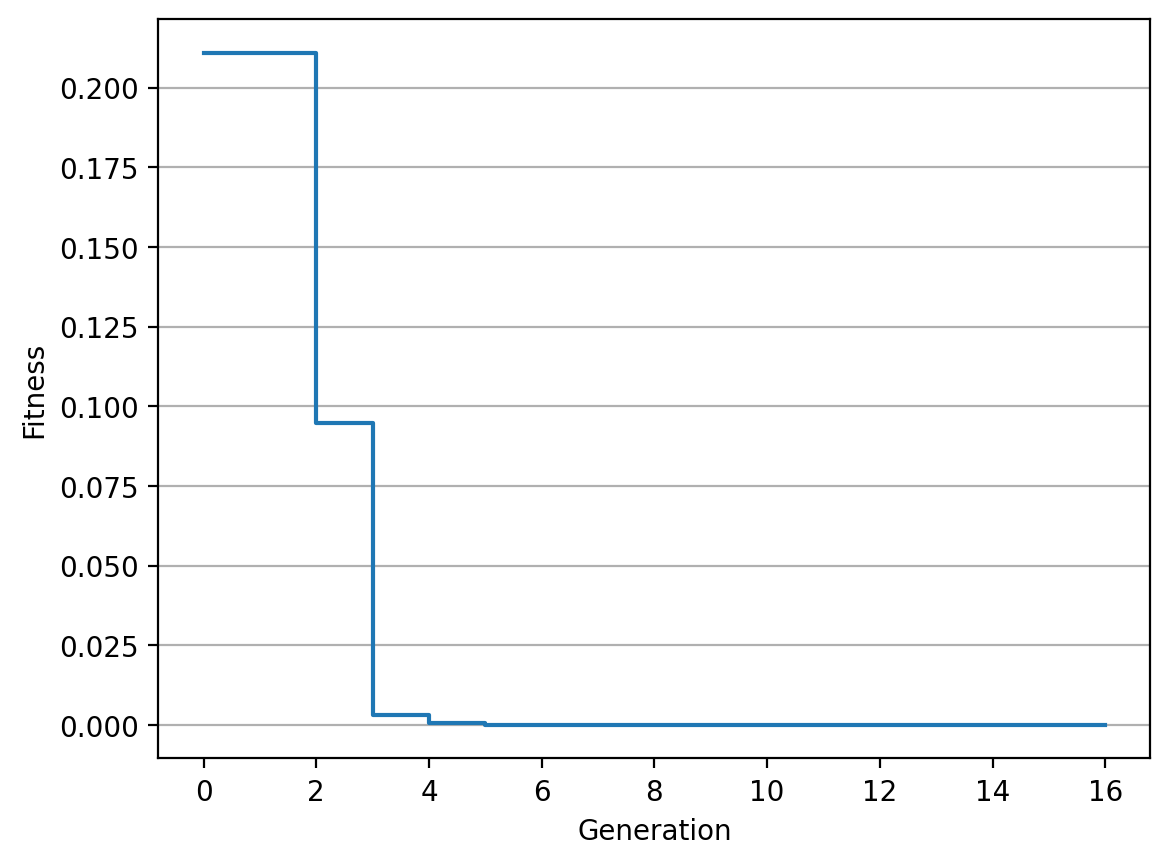

olr: [0.5725868570246655], w: [0.7666331885515543, 0.2333668114484458], means: [[24.413001629006242, 30.03402485309473], [24.609252204268323, 6.341603386745384]], cov: [array([[211.09353155,  18.08554518],
       [ 18.08554518, 131.03673756]]), array([[195.97518875,   3.84022391],
       [  3.84022391,  19.52202091]])]
olr: [0.14538286307533504], w: [0.4080255923649888, 0.5919744076350112], means: [[9.817489397195066, 10.215650493296115], [34.652195785159996, 34.7132458617183]], cov: [array([[3.81875229e+01, 1.43166112e-02],
       [1.43166112e-02, 3.85333803e+01]]), array([[73.47355984,  2.3488016 ],
       [ 2.3488016 , 75.74735119]])]
olr: [0.10768359617437213], w: [0.7651338742491056, 0.23486612575089447], means: [[18.285026788668542, 30.876423708854315], [43.16206340964337, 5.758183732812034]], cov: [array([[117.72906602,   2.39799064],
       [  2.39799064, 121.96297919]]), array([[12.6322449 , -0.3953726 ],
       [-0.3953726 , 12.92874339]])]
olr: [0.23846995426069487], w: [0.2

In [120]:
plt.rcParams['figure.dpi'] = 200
optimiser.history.show()

In [46]:
optimized_graph

{'depth': 2, 'length': 2, 'nodes': [Comp_0, Comp_1]}

In [121]:
for node in optimized_graph.nodes:
    w = node.content['w']
    mean = node.content['mean']
    var = node.content['var']
    
    print(w, mean, var)

[0.74985104 0.25014896] [[-0.6748119634074365], [19.487109257922597]] [[[6]], [[5]]]
[0.74985104 0.25014896] [[7.953276716448512], [10.38720637342482]] [[[37]], [[40]]]


In [124]:
data = bn.sample(5000)

gmm = GMM(n_components=number_of_components)
gmm.from_samples(data.to_numpy().astype('int'))

w = gmm.priors.tolist()
means = gmm.means.tolist()
cov = make_diagonal(gmm.covariances.tolist())

100%|██████████| 5000/5000 [00:00<00:00, 21337.18it/s]


In [126]:
w, means, cov

([0.7550468486011945, 0.24495315139880555],
 [[18.543394229522, 23.29533220084879],
  [42.52269695306556, 28.646019839144486]],
 [array([[130.2911039 , -10.52985576],
         [-10.52985576, 204.69597956]]),
  array([[ 19.73064748,  -2.90578274],
         [ -2.90578274, 193.93661822]])])

In [111]:
optimiser.best_individuals[0]

<Individual 23b07bc9-85bf-4c8f-8ffa-219e3fdaf710 | fitness: 0.0002 | native_generation: 3 | graph: {'depth': 2, 'length': 2, 'nodes': [Comp_0, Comp_1]}>

In [ ]:
# [0.5, 0.5] [[14], [3]] [[[37]], [[35]]]
# [0.5, 0.5] [[16], [12]] [[[28]], [[23]]]

# [0.74985104 0.25014896] [[-0.6748119634074365], [19.487109257922597]] [[[6]], [[5]]]
# [0.74985104 0.25014896] [[7.953276716448512], [10.38720637342482]] [[[37]], [[40]]]

In [ ]:
olr: [0.14072068123861659], w: [0.5165915620698648, 0.48340843793013527], means: [[36.700183557848526, 36.89171049478641], [12.089972762215126, 12.126502535142556]],
    cov: [array([[53.49434029,  0.60960388],
                 [0.60960388, 55.91087547]]),
        array([[54.77838081,  0.99271228],
               [ 0.99271228, 58.27632169]])]
                
olr: [0.29801285359437096], w: [0.42330955045693874, 0.5766904495430613], means: [[37.34580634588582, 37.79603519615378], [14.418764019518049, 14.487108879089686]],
    cov: [array([[53.28750735, -4.85484793],
                 [-4.85484793, 55.81569782]]),
          array([[9.78957820e+01, -8.87155581e-03],
                 [-8.87155581e-03, 8.20472549e+01]])]

olr: [0.6543998232604697], w: [0.716150863889959, 0.28384913611004103], means: [[22.935533562856268, 17.519706215268254], [28.082163414064713, 40.99165992996546]],
    cov: [array([[203.99654261, 62.31500296],
                 [62.31500296, 116.03476483]]),
          array([[196.0187708 ,  19.88611612],
                 [19.88611612, 28.81560215]])]
                
olr: [0.617], w: [0.7550468486011945, 0.24495315139880555], means: [[18.543394229522, 23.29533220084879], [42.52269695306556, 28.646019839144486]],
    cov: [array([[130.2911039 , -10.52985576],
                 [-10.52985576, 204.69597956]]),
      array([[ 19.73064748,  -2.90578274],
             [ -2.90578274, 193.93661822]])]

In [ ]:
График для разных таргетных ОЛР по оси y - отклонение от таргетного значения, по оси x - кол-во узлов.
Барплоты.
Также для разного кол-во компонент.

In [5]:
# optimiser.history.to_csv('./history', 'criteria-2-olr-0.6-4.csv')

In [6]:
# historical_fitness = optimiser.history.historical_fitness

In [7]:
# with open('./history/criteria-2-olr-0.6-4.json', 'w') as f:
#     f.write(json.dumps(historical_fitness))

[0.49219683529115027, 0.5078031647088497] [[2.9463139315296645, 19.806163310597395, 10.846299915608604, 14.682398092952065], [4.990072852396739, 19.175716033736762, 16.92178844077739, 12.567433084594677]] [array([[ 5.91106690e+00,  7.27608332e-01, -7.54856373e-02,
        -1.72639339e+00],
       [ 7.27608332e-01,  2.41939604e+01, -3.08663135e-01,
        -5.91276535e-03],
       [-7.54856373e-02, -3.08663135e-01,  4.37156878e+00,
        -2.98555145e-01],
       [-1.72639339e+00, -5.91276535e-03, -2.98555145e-01,
         3.79778863e+01]]), array([[ 1.02839578,  0.09547921, -0.40214553, -0.19654509],
       [ 0.09547921, 26.59930995,  2.09591959, -2.12143596],
       [-0.40214553,  2.09591959, 40.79508397,  2.63282237],
       [-0.19654509, -2.12143596,  2.63282237, 49.87573984]])]
[0.5034, 0.4966] [[4.958623024129207, 19.461782725889194, 4.998814929516386, 12.682540787383806], [3.0594887943044142, 19.467036322908807, -853.9656456530303, 14.288529891660433]] [array([[ 3.54399571e+01, 

In [8]:
# to_df = {'iteration': [], 'losses': []}

# for i in range(len(historical_fitness)):
#     losses = historical_fitness[i]
    
#     for loss in losses:
#         to_df['iteration'].append(i)
#         to_df['losses'].append(loss)

# df = pd.DataFrame.from_dict(to_df)

<AxesSubplot: xlabel='iteration', ylabel='losses'>

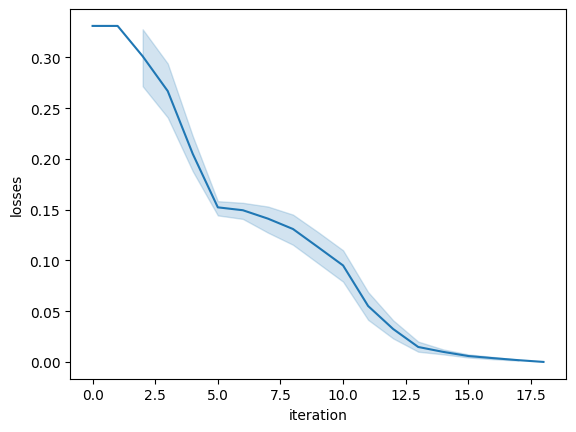

In [9]:
# sns.lineplot(data=df, x="iteration", y="losses")

In [8]:
# !help bn.sample

/bin/sh: 1: help: not found
